In [1]:
import os, importlib, submitted
import numpy as np
import IPython.display
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io.wavfile
import soundfile as sf
import glob
import random
import librosa
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import librosa.display

## Getting in data

Reading datasets

### Helper functions

In [2]:
#print(glob.glob('./datasets/libri/**/**/*.flac'))

In [3]:
def extract_audio(waveform,sample_rate=16000,window_length=0.05,thresh=1e-5):
    thresh = 5e-6
    sample_length = int(window_length * sample_rate)
    nframes = int((len(waveform))/sample_length) + 1
    
    if len(waveform) % nframes != 0:
        pad_amt = nframes * sample_length - len(waveform)
        waveform = np.pad(waveform, (0,pad_amt))
    
    split = np.array(np.split(waveform, nframes))
    means = np.mean(split**2,axis=1)
    out = np.array([])
    for i in range(len(means)):
        if means[i] > thresh:
            out = np.append(out, split[i])
    
    return out

Text(0.5, 1.0, 'Filter then extract')

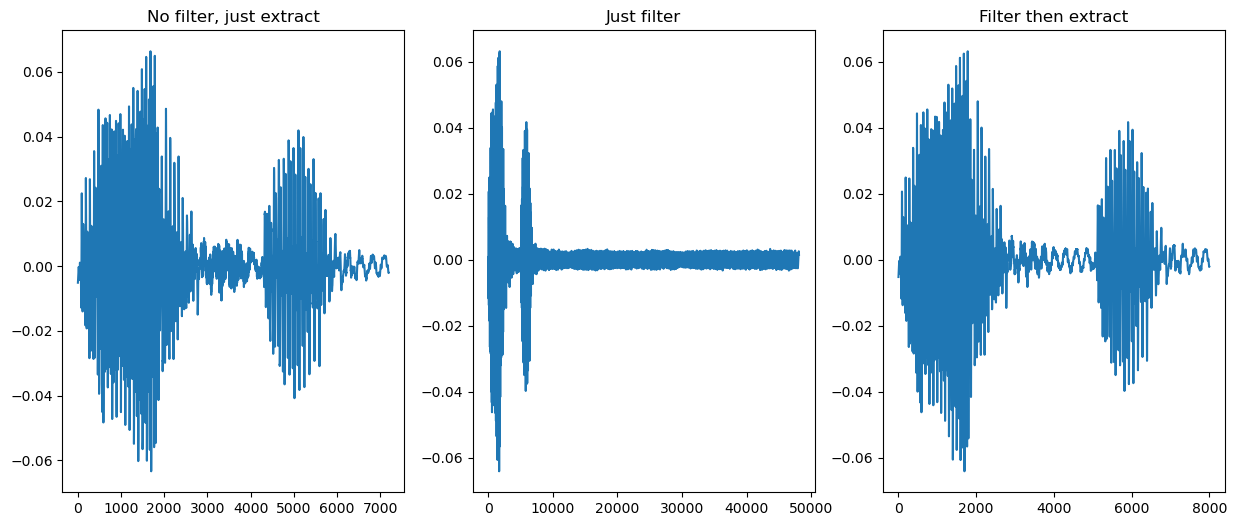

In [4]:
plt.figure(figsize=(15,6))
rate = 16000
file = os.path.join("datasets/0", str(199)+".wav")

wav,sr0 = librosa.load(file, sr=rate) # read file

wav1 = extract_audio(wav,sr0)
plt.subplot(131)
plt.plot(wav1)
plt.title("No filter, just extract")

wav2 = signal.savgol_filter(wav,11,2)
plt.subplot(132)
plt.plot(wav2)
plt.title("Just filter")

wav3 = extract_audio(wav2,sr0,window_length=0.1,thresh=5e-6)
plt.subplot(133)
plt.plot(wav3)
plt.title("Filter then extract")

In [5]:
IPython.display.Audio(data=wav3,rate=16000)

 Best results from first savgol filter and then extracting audio.

In [6]:
def process_audio(file):
    wav,sr0 = librosa.load(file, sr=rate) # read file
    wav = signal.savgol_filter(wav,11,2) # clean background noise
    wav = extract_audio(wav,sr0,window_length=0.1,thresh=5e-6) # threshold, only keep significant part of signal
    
    return wav

In [7]:
def chunk(file):
    wav,sr1 = librosa.load(file, sr=rate)
    
    r = random.randint(30,120)/100
    l = int(r*sr1) # grab 0.3-1.2 second long chunk
    if(len(wav) > l): 
        start = random.randint(0,len(wav)-l)
        wav = wav[start:start+l] 
    
    wav = signal.savgol_filter(wav,11,2) # clean background noise
    
    return wav

### Reading the data 

In [8]:
train_zero = {}
train_one = {}

dev_zero = {}
dev_one = {}

test_zero = {}
test_one = {}

rate = 16000

In [9]:
### 0 class (password) train, dev, and test sets - my recordings of the password ("hamster")

randomlist = [i for i in range(250)]
random.shuffle(randomlist) # randomize order of recordings

for idx, i in enumerate(randomlist[0:150]):
    
    # train set - 150 items
    file = os.path.join("datasets/0", str(i)+".wav")
    train_zero[idx] = process_audio(file)

print("Size of 0 class train set =", len(train_zero.keys()))

for idx, i in enumerate(randomlist[150:200]):
    
    # dev set - 50 items
    file = os.path.join("datasets/0", str(i)+".wav")
    dev_zero[idx] = process_audio(file)

print("Size of 0 class dev set =", len(dev_zero.keys()))

for idx, i in enumerate(randomlist[200:250]):
    
    # train set - 50 items
    file = os.path.join("datasets/0", str(i)+".wav")
    test_zero[idx] = process_audio(file)

print("Size of 0 class test set =", len(test_zero.keys()))

Size of 0 class train set = 150
Size of 0 class dev set = 50
Size of 0 class test set = 50


In [10]:
### 1 class (oov) train set - 900 random from librispeech + 100 of my recordings
    
# 900 random 0.3-1.2s "chunks" from librispeech dataset
for i in range(900): # 950 from libri
    
    # train set
    choices = glob.glob('./datasets/libri/**/**/*.flac') 
    file = random.choice(choices) # choose random file from librispeech dataset
    train_one[i] = chunk(file) # clean background noise

randomlist = [i for i in range(200)]
random.shuffle(randomlist) # randomize order of recordings

for idx, i in enumerate(randomlist[0:100]): # 100 from my recordings
    
    file = os.path.join("datasets/1", str(i)+".wav")
    train_one[idx + 900] = process_audio(file) 

print("Size of 1 class train set =", len(train_one.keys()))

Size of 1 class train set = 1000


In [11]:
### 1 class (oov) dev set - 100 total items, contains both random words I recorded and chunks from librispeech dataset

# 50 random words recorded by me
for idx, i in enumerate(randomlist[100:150]):
    file = os.path.join("datasets/1", str(i)+".wav")
    dev_one[idx] = process_audio(file)

# 50 random chunks from librispeech
for i in range(50):
    choices = glob.glob('./datasets/libri/**/**/*.flac') 
    file = random.choice(choices) # choose random file from librispeech dataset
    dev_one[i+50] = chunk(file) 

print("Size of 1 class dev set =", len(dev_one.keys()))

Size of 1 class dev set = 100


In [12]:
### 1 class (oov) test set - 100 total items, contains both random words I recorded and chunks from librispeech dataset

# 50 random words recorded by me
for idx, i in enumerate(randomlist[150:200]):
    file = os.path.join("datasets/1", str(i)+".wav")
    test_one[idx] = process_audio(file)

# 50 random chunks from librispeech
for i in range(50):
    choices = glob.glob('./datasets/libri/**/**/*.flac') 
    file = random.choice(choices) # choose random file from librispeech dataset
    test_one[i+50] = chunk(file) 

print("Size of 1 class test set =", len(test_one.keys()))

Size of 1 class test set = 100


In [13]:
IPython.display.Audio(data=train_zero[0],rate=rate) # password

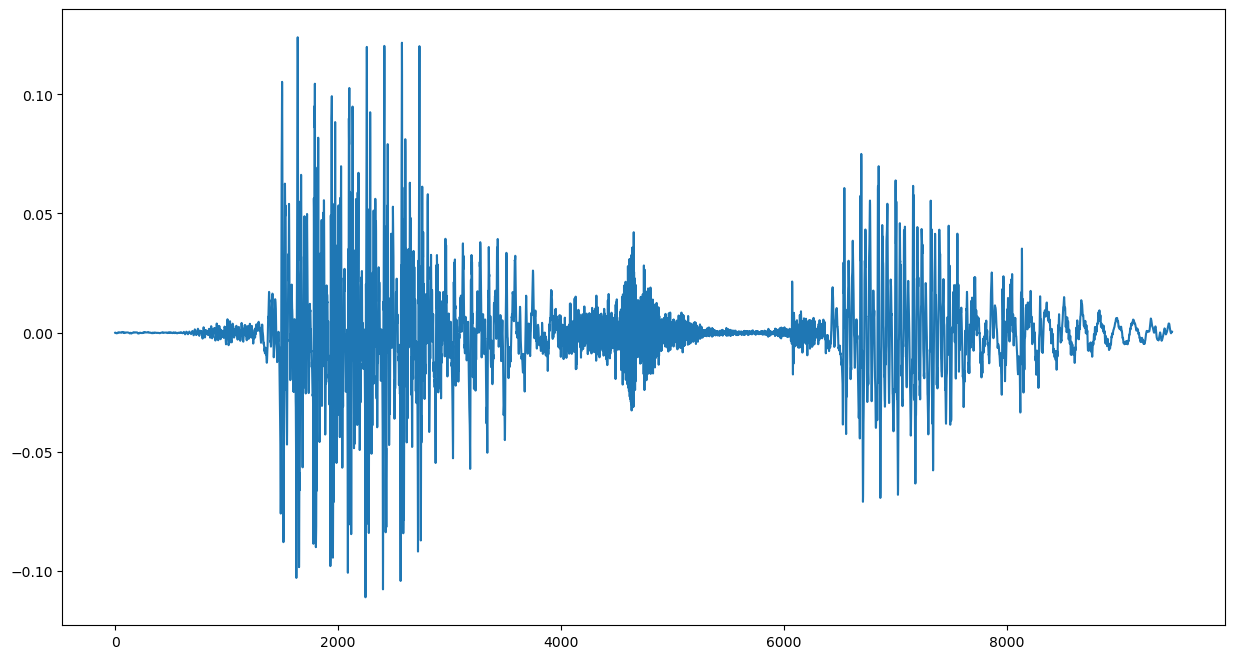

In [14]:
plt.figure(figsize=(15,8))
plt.plot(train_zero[0])
plt.show()

In [15]:
IPython.display.Audio(data=train_one[0],rate=rate) # libri

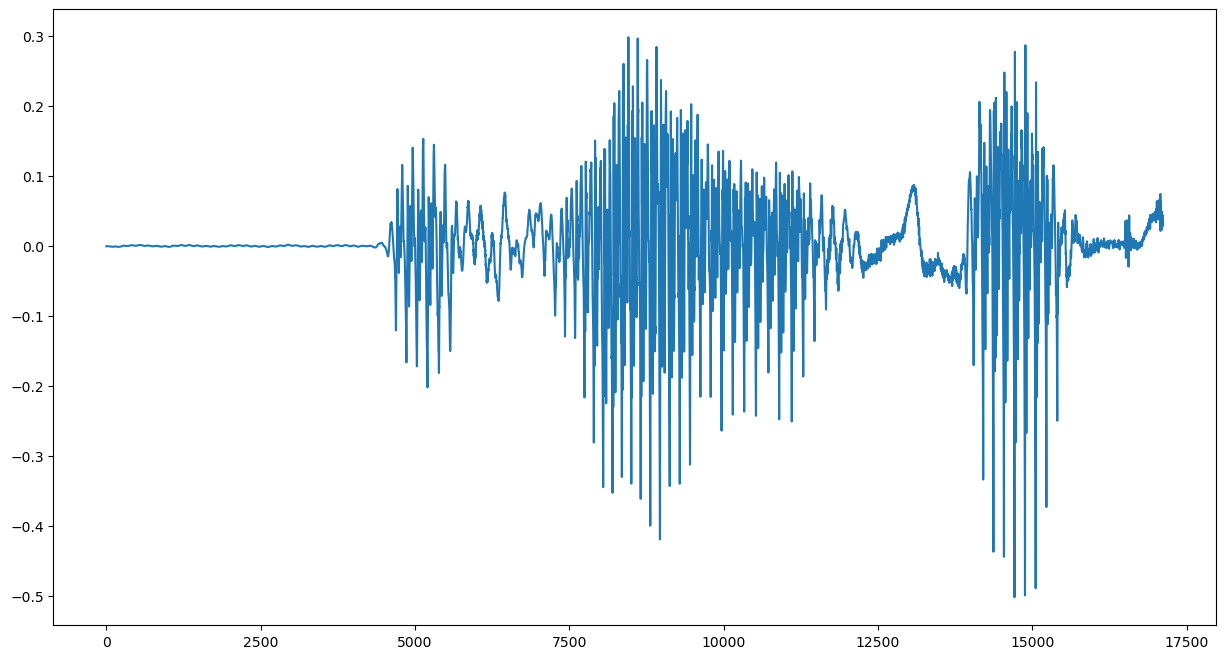

In [16]:
plt.figure(figsize=(15,8))
plt.plot(train_one[0])
plt.show()

In [17]:
IPython.display.Audio(data=dev_zero[0],rate=rate) # password

In [18]:
IPython.display.Audio(data=dev_one[0],rate=rate) # random recorded word

In [19]:
IPython.display.Audio(data=train_one[950],rate=rate) # random word I recorded

In [20]:
IPython.display.Audio(data=dev_one[50],rate=rate) # libri

In [21]:
IPython.display.Audio(data=test_zero[0],rate=rate)

In [22]:
IPython.display.Audio(data=test_one[0],rate=rate)

In [23]:
IPython.display.Audio(data=test_one[50],rate=rate)

## Turning data into input features

Take spectrogram and use liftering to get rid of speaker dependent information

### Testing and visualizing

[Text(0.5, 1.0, 'MFCC')]

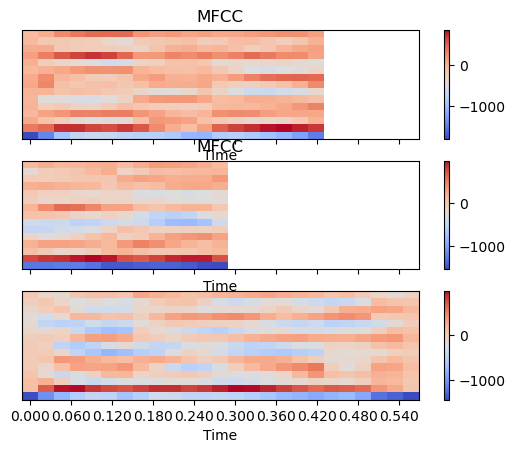

In [24]:
import librosa.display
import librosa.feature
n= 15
L = 2*n

wav = train_zero[0]
mfccs = librosa.feature.mfcc(y=wav,sr=rate,lifter=L,n_mfcc=n)
fig, ax = plt.subplots(nrows=3, sharex=True)

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='MFCC')

wav = train_zero[4]
mfccs = librosa.feature.mfcc(y=wav,sr=rate,lifter=L,n_mfcc=n)

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')


wav = train_one[980]
mfccs = librosa.feature.mfcc(y=wav,sr=rate,lifter=L,n_mfcc=n)

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[2])
fig.colorbar(img, ax=[ax[2]])
ax[1].set(title='MFCC')

[Text(0.5, 1.0, 'MFCC of OOV Word')]

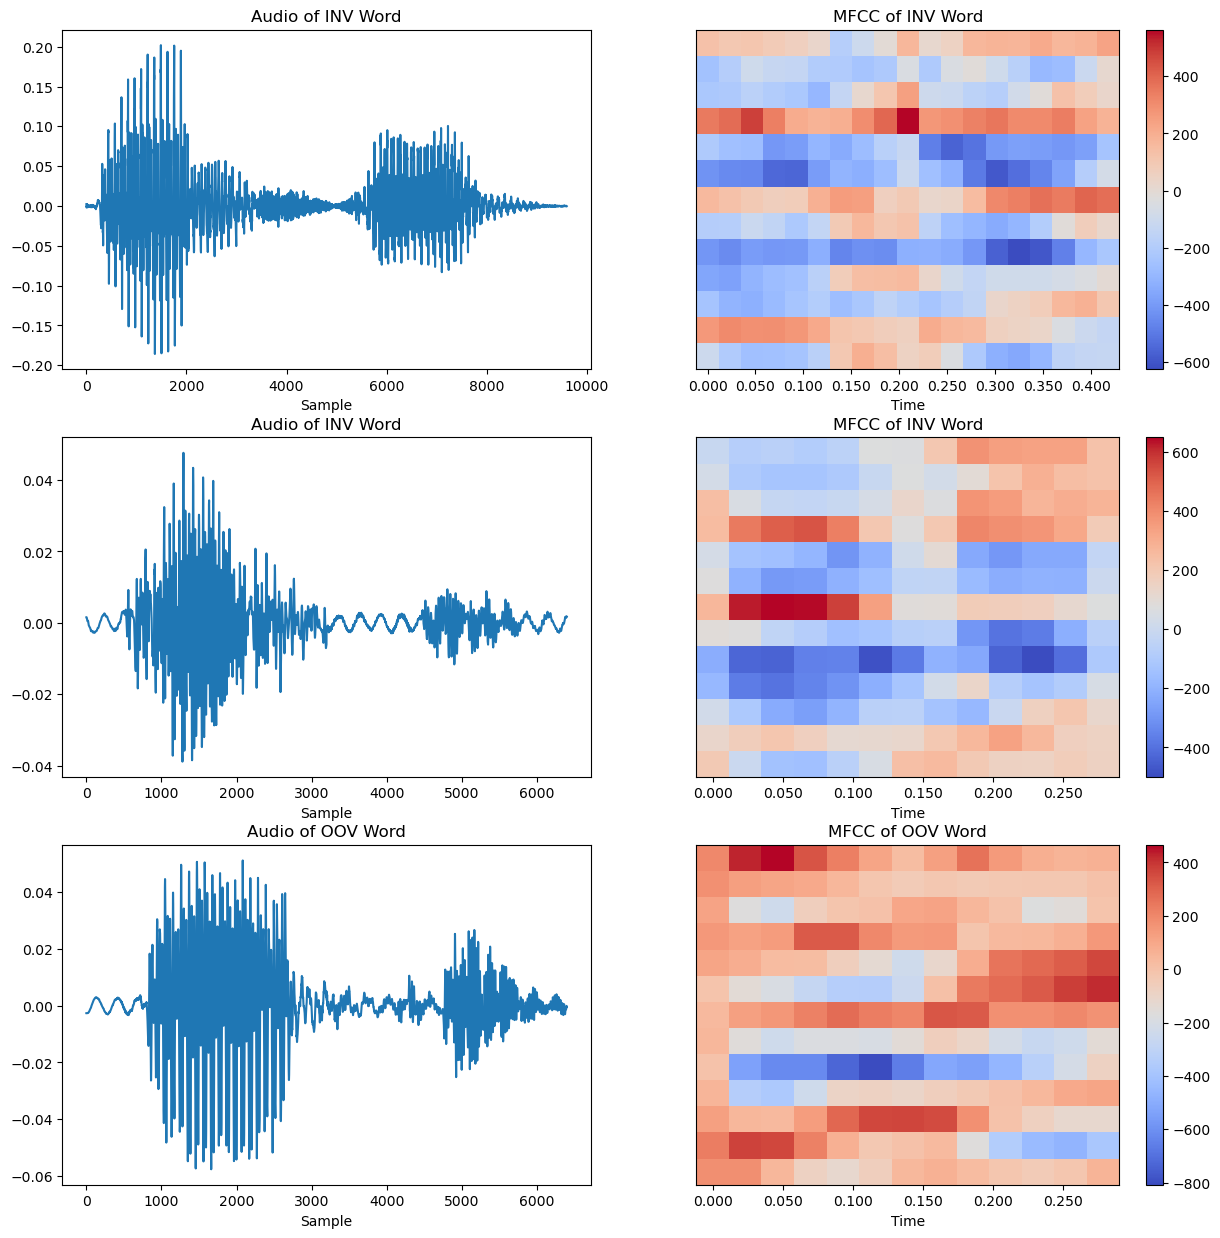

In [25]:
wav0 = train_zero[50]
wav1 = train_zero[100]
wav2 = train_one[950]


fig, ax = plt.subplots(nrows=3,ncols=2)

fig.set_figheight(15)
fig.set_figwidth(15)
#fig.suptitle('Comparison of MFCCs and Audio of INV and OOV Words')

ax[0,0].plot(wav0)
ax[0,0].set(title="Audio of INV Word")
ax[0,0].set(xlabel="Sample")

mfccs = librosa.feature.mfcc(y=wav0,sr=rate,lifter=L,n_mfcc=n)
mfccs = mfccs[2:,]
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[0,1])
fig.colorbar(img, ax=[ax[0,1]])
ax[0,1].set(title='MFCC of INV Word')

ax[1,0].plot(wav1)
ax[1,0].set(title="Audio of INV Word")
mfccs = librosa.feature.mfcc(y=wav1,sr=rate,lifter=L,n_mfcc=n)
mfccs = mfccs[2:,]
ax[1,0].set(xlabel="Sample")

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1,1])
fig.colorbar(img, ax=[ax[1,1]])
ax[1,1].set(title='MFCC of INV Word')

ax[2,0].plot(wav2)
ax[2,0].set(title="Audio of OOV Word")
mfccs = librosa.feature.mfcc(y=wav2,sr=rate,lifter=L,n_mfcc=n)
mfccs = mfccs[2:,]
ax[2,0].set(xlabel="Sample")

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[2,1])
fig.colorbar(img, ax=[ax[2,1]])
ax[2,1].set(title='MFCC of OOV Word')

[Text(0.5, 1.0, 'MFCC')]

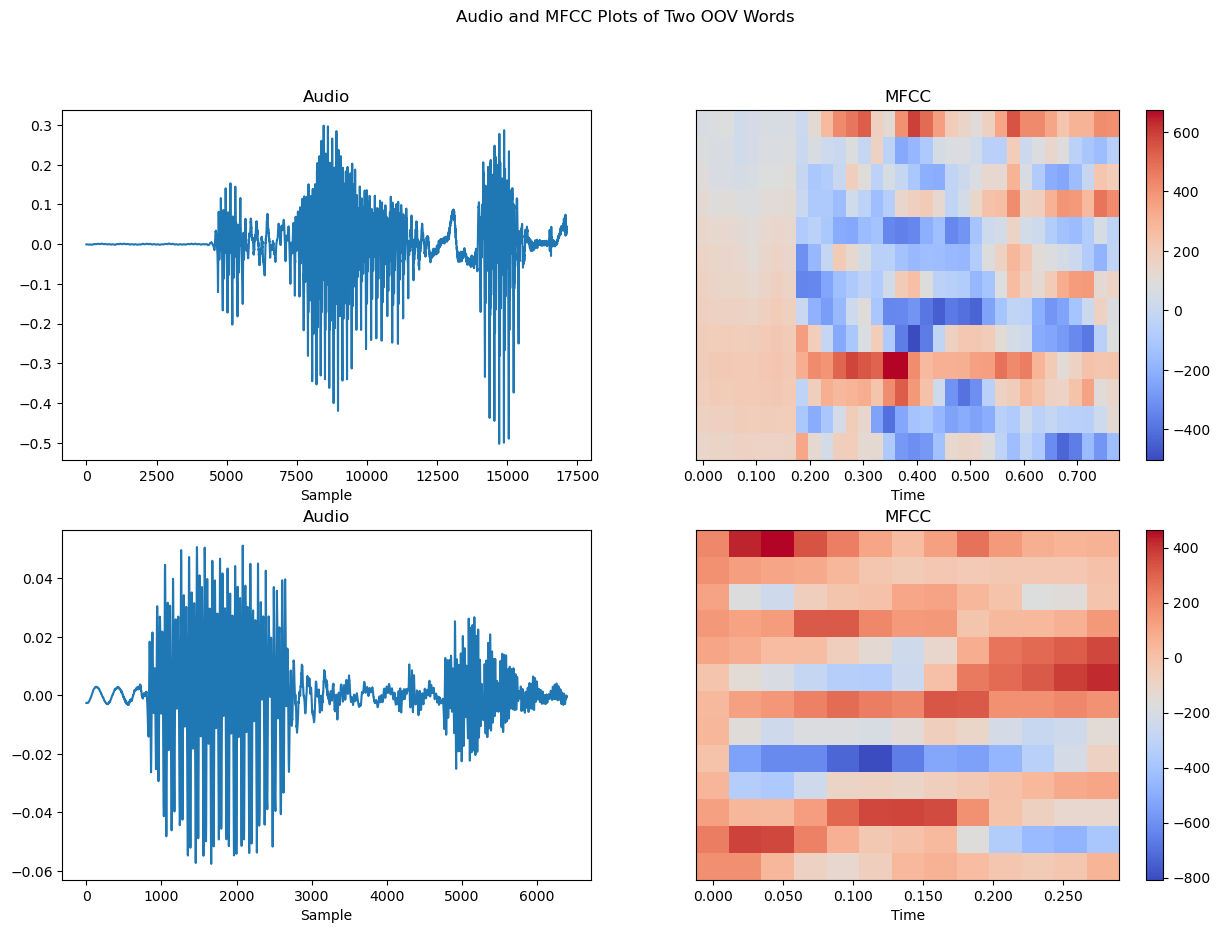

In [26]:
wav0 = train_one[0]
wav1 = train_one[950]


fig, ax = plt.subplots(nrows=2,ncols=2)

fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('Audio and MFCC Plots of Two OOV Words')

ax[0,0].plot(wav0)
ax[0,0].set(title="Audio")
ax[0,0].set(xlabel="Sample")

mfccs = librosa.feature.mfcc(y=wav0,sr=rate,lifter=L,n_mfcc=n)
mfccs = mfccs[2:,]
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[0,1])
fig.colorbar(img, ax=[ax[0,1]])
ax[0,1].set(title='MFCC')

ax[1,0].plot(wav1)
ax[1,0].set(title="Audio")
mfccs = librosa.feature.mfcc(y=wav1,sr=rate,lifter=L,n_mfcc=n)
mfccs = mfccs[2:,]
ax[1,0].set(xlabel="Sample")


img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1,1])
fig.colorbar(img, ax=[ax[1,1]])
ax[1,1].set(title='MFCC')

### Transforming the data into input features

In [27]:
train_feat = {0:[],1:[]}
for i in range(len(train_zero.keys())):

    wav = train_zero[i]
    mfccs = np.array(librosa.feature.mfcc(y=wav,sr=rate,lifter=L,n_mfcc=n))
    mfccs = mfccs[2:,]
    train_feat[0].append(mfccs.T)

    
for i in range(len(train_one.keys())):
    
    wav = train_one[i]
    mfccs = np.array(librosa.feature.mfcc(y=wav,sr=rate,lifter=L,n_mfcc=n))
    mfccs = mfccs[2:,]
    train_feat[1].append(mfccs.T)
    
print("Number of training features for class 0 =", len(train_feat[0]))
print("Number of training features for class 1 =", len(train_feat[1]))

Number of training features for class 0 = 150
Number of training features for class 1 = 1000


In [28]:
dev_feat = {0:[],1:[]}
for i in range(len(dev_zero.keys())):

    wav = dev_zero[i]
    mfccs = np.array(librosa.feature.mfcc(y=wav,sr=rate,lifter=L,n_mfcc=n))
    mfccs = mfccs[2:,]
    dev_feat[0].append(mfccs.T)

    
for i in range(len(dev_one.keys())):
    
    wav = dev_one[i]
    mfccs = np.array(librosa.feature.mfcc(y=wav,sr=rate,lifter=L,n_mfcc=n))
    mfccs = mfccs[2:,]
    dev_feat[1].append(mfccs.T)
    
print("Number of validation features for class 0 =", len(dev_feat[0]))
print("Number of validation features for class 1 =", len(dev_feat[1]))

Number of validation features for class 0 = 50
Number of validation features for class 1 = 100


In [29]:
test_feat = {0:[],1:[]}
for i in range(len(test_zero.keys())):

    wav = test_zero[i]
    mfccs = np.array(librosa.feature.mfcc(y=wav,sr=rate,lifter=L,n_mfcc=n))
    mfccs = mfccs[2:,]
    test_feat[0].append(mfccs.T)

    
for i in range(len(test_one.keys())):
    
    wav = test_one[i]
    mfccs = np.array(librosa.feature.mfcc(y=wav,sr=rate,lifter=L,n_mfcc=n))
    mfccs = mfccs[2:,]
    test_feat[1].append(mfccs.T)
    
print("Number of test features for class 0 =", len(test_feat[0]))
print("Number of test features for class 1 =", len(test_feat[1]))

Number of test features for class 0 = 50
Number of test features for class 1 = 100


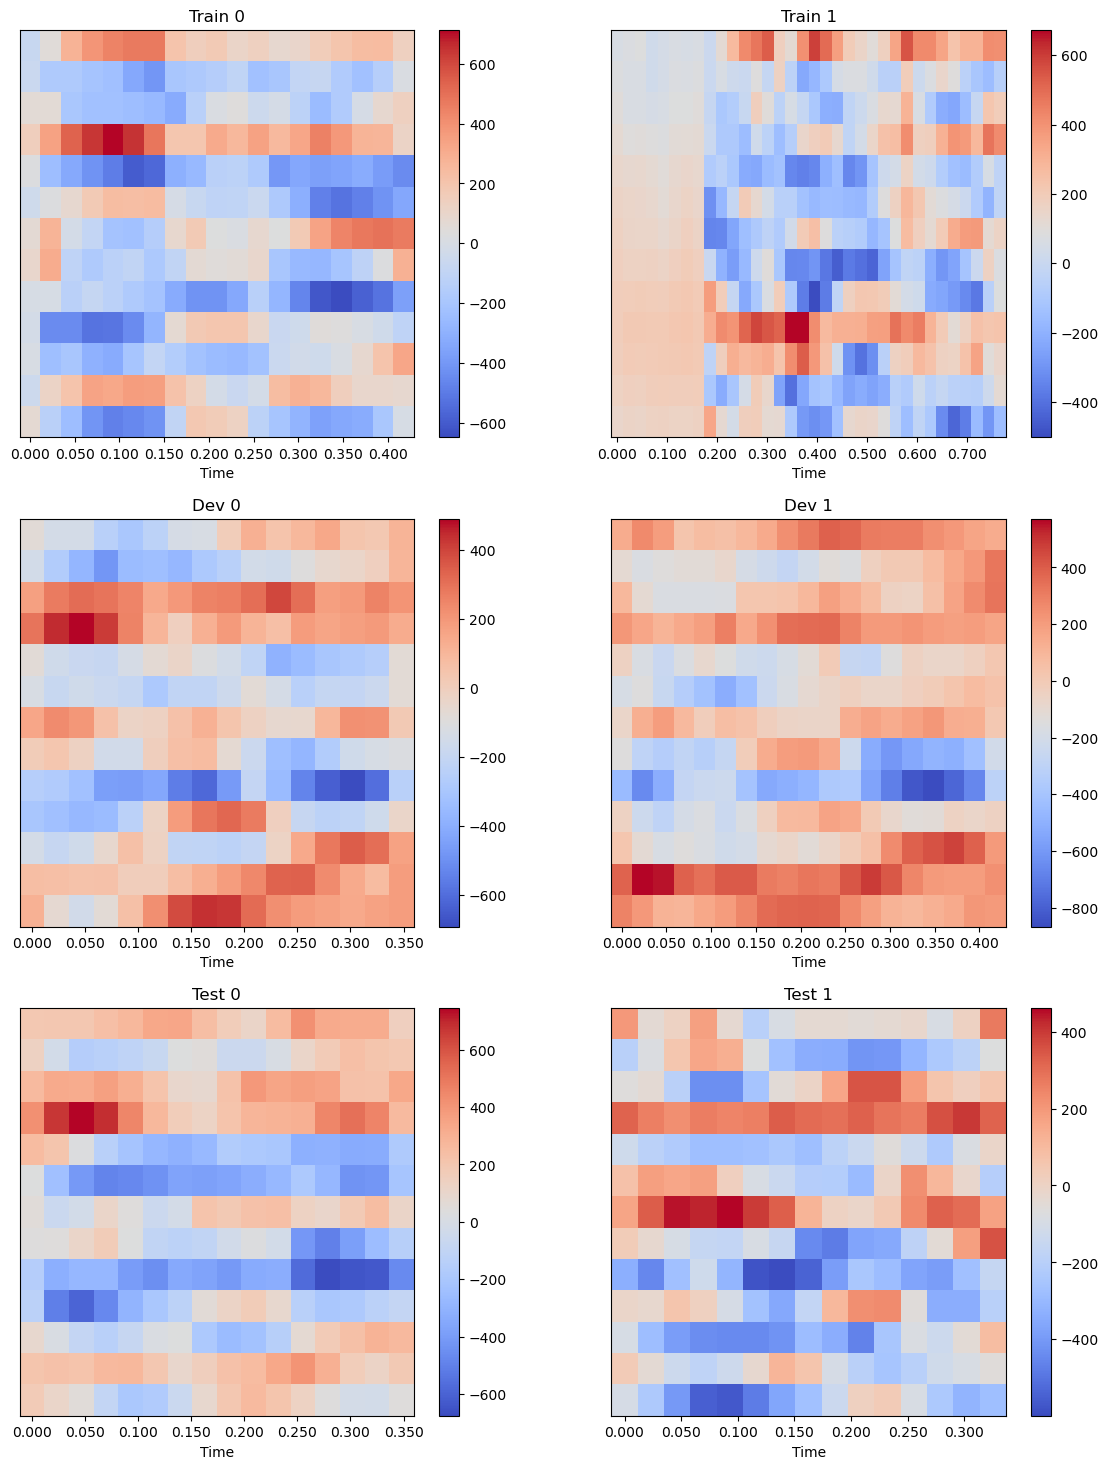

In [30]:
fig, ax = plt.subplots(3,2,figsize=(14,18))

img = librosa.display.specshow(train_feat[0][0].T, x_axis='time', ax=ax[0,0])
fig.colorbar(img, ax=[ax[0,0]])
ax[0,0].set(title='Train 0')

img = librosa.display.specshow(train_feat[1][0].T, x_axis='time', ax=ax[0,1])
fig.colorbar(img, ax=[ax[0,1]])
ax[0,1].set(title='Train 1')

img = librosa.display.specshow(dev_feat[0][0].T, x_axis='time', ax=ax[1,0])
fig.colorbar(img, ax=[ax[1,0]])
ax[1,0].set(title='Dev 0')

img = librosa.display.specshow(dev_feat[1][0].T, x_axis='time', ax=ax[1,1])
fig.colorbar(img, ax=[ax[1,1]])
ax[1,1].set(title='Dev 1')


img = librosa.display.specshow(test_feat[0][0].T, x_axis='time', ax=ax[2,0])
fig.colorbar(img, ax=[ax[2,0]])
ax[2,0].set(title='Test 0')

img = librosa.display.specshow(test_feat[1][0].T, x_axis='time', ax=ax[2,1])
fig.colorbar(img, ax=[ax[2,1]])
ax[2,1].set(title='Test 1')

plt.show()

## HMM Testing

Data is in the form we want, we can start training the HMM

### Initialize HMM

Get A, mu, sigma

In [31]:
nstates = 5
importlib.reload(submitted)

Lambda = {
    0: submitted.initialize_hmm(train_feat[0], nstates),
    1: submitted.initialize_hmm(train_feat[1], nstates)
}

C:\Users\amant\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
C:\Users\amant\Documents\UIUC\SP2023\ECE445\HMM\submitted.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  q = np.array(q)


In [32]:
importlib.reload(submitted)
B_dict = { y:[] for y in [0,1] }
for y in [0,1]:
    for X in train_feat[y]:
        B = submitted.observation_pdf(X, Lambda[y][1], Lambda[y][2])
        B_dict[y].append(B)
    print('B_dict[%s] is a list of %d B matrices'%(y,len(B_dict[y])))

B_dict[0] is a list of 150 B matrices
B_dict[1] is a list of 1000 B matrices


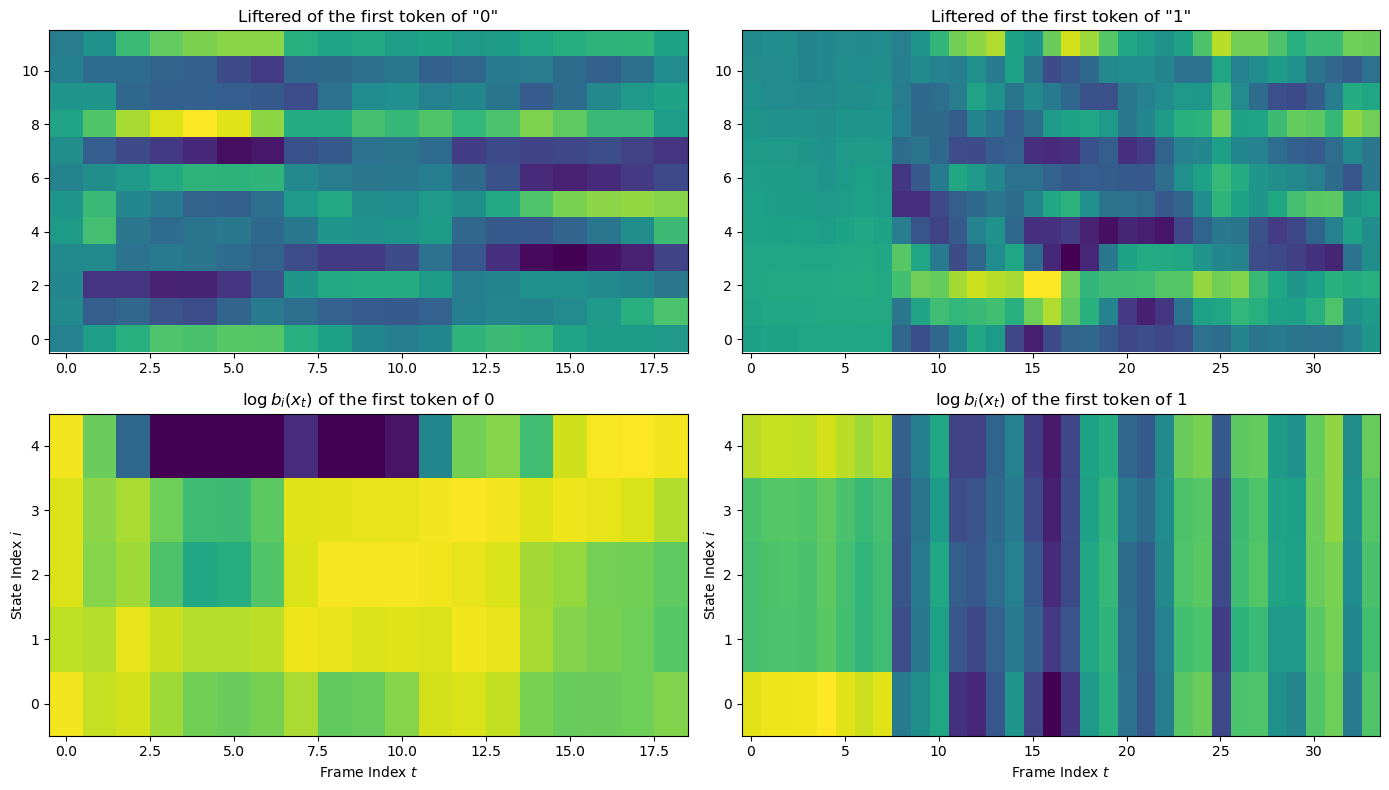

In [33]:
fig, axs = plt.subplots(2,2,figsize=(14,8))
Y=[0,1]
for col in range(2):
    y = Y[col]
    normalized_B = np.log(B_dict[y][0])
    axs[0,col].imshow(train_feat[y][0][:,1:].T,aspect='auto',origin='lower')
    axs[0,col].set_title('Liftered of the first token of "%s"'%(y))
    axs[1,col].imshow(normalized_B.T,aspect='auto',origin='lower')
    axs[1,col].set_title('$\log b_i(x_t)$ of the first token of %s'%(y))
    axs[1,col].set_ylabel('State Index $i$')
    axs[1,col].set_xlabel('Frame Index $t$')
fig.tight_layout()

In [34]:
importlib.reload(submitted)
Alpha_dict = { y:[] for y in [0,1] }
G_dict = { y:[] for y in [0,1] }
for y in [0,1]:
    for B in B_dict[y]:
        Alpha_Hat, G = submitted.scaled_forward(Lambda[y][0], B)
        Alpha_dict[y].append(Alpha_Hat)
        G_dict[y].append(G)
    print('Alpha_dict[%s] is a list of %d Alpha_Hat matrices'%(y,len(Alpha_dict[y])))

Alpha_dict[0] is a list of 150 Alpha_Hat matrices
Alpha_dict[1] is a list of 1000 Alpha_Hat matrices


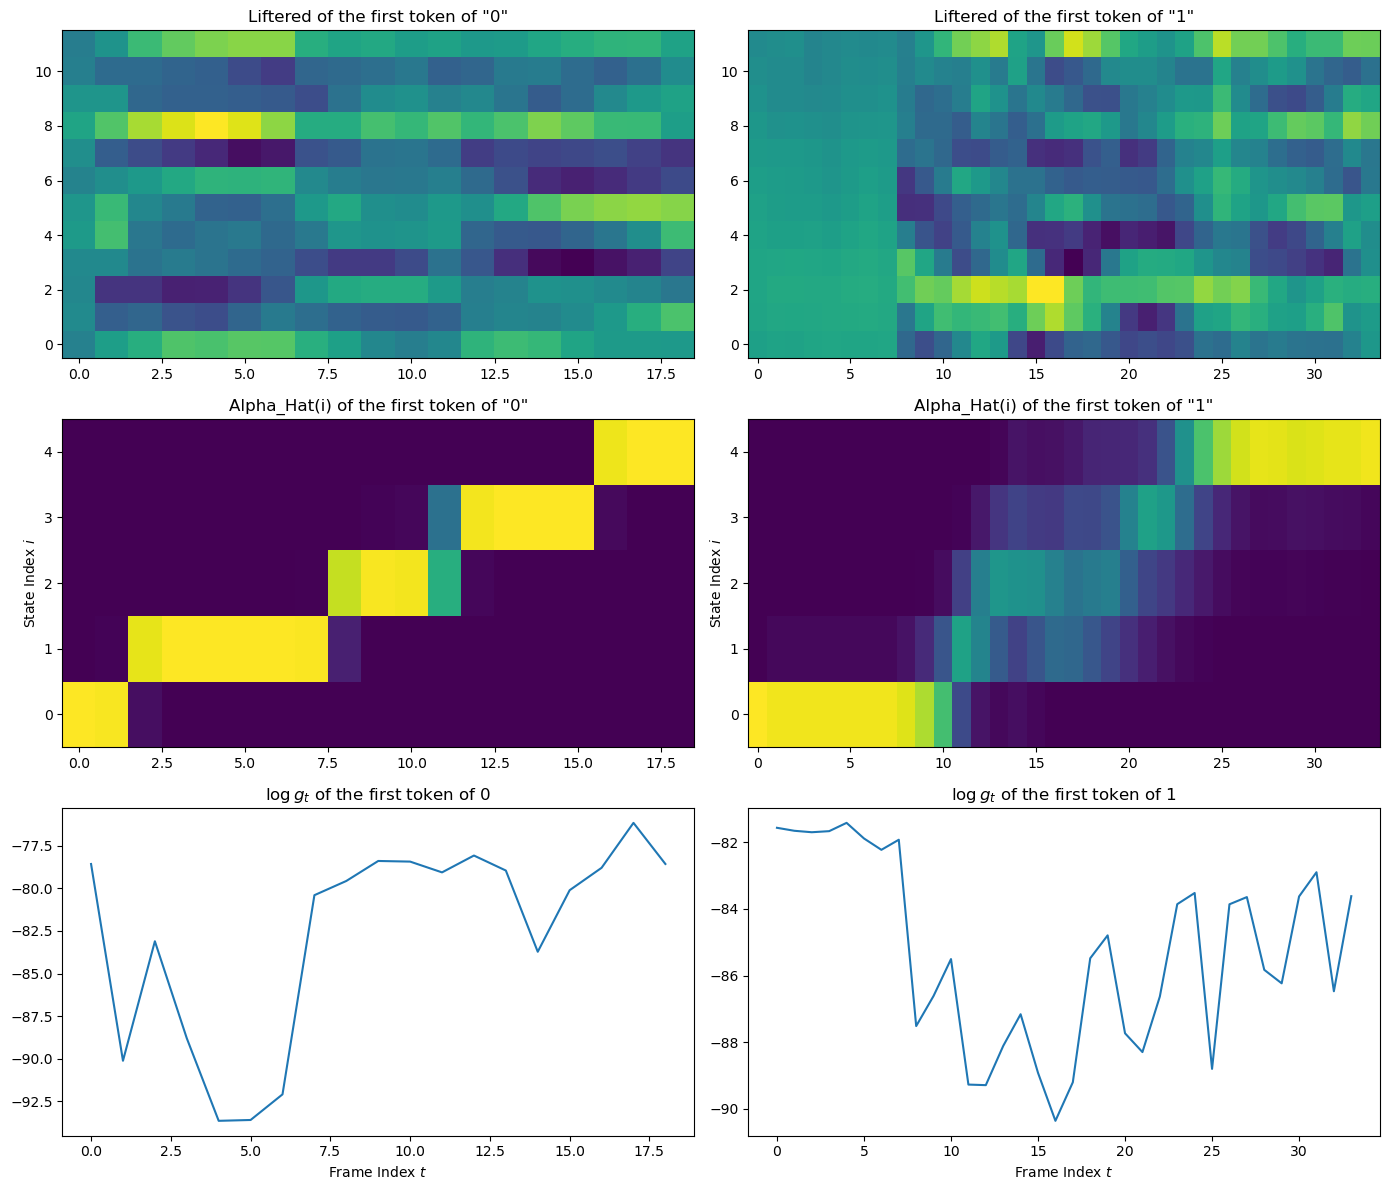

In [35]:
fig, axs = plt.subplots(3,2,figsize=(14,12))
Y=[0,1]
for col in range(2):
    y = Y[col]
    axs[0,col].imshow(train_feat[y][0][:,1:].T,aspect='auto',origin='lower')
    axs[0,col].set_title('Liftered of the first token of "%s"'%(y))
    axs[1,col].imshow(Alpha_dict[y][0].T,aspect='auto',origin='lower')
    axs[1,col].set_title('Alpha_Hat(i) of the first token of "%s"'%(y))
    axs[1,col].set_ylabel('State Index $i$')
    axs[2,col].plot(np.log(G_dict[y][0]))
    axs[2,col].set_title('$\log g_t$ of the first token of %s'%(y))
    axs[2,col].set_xlabel('Frame Index $t$')
fig.tight_layout()


In [36]:
importlib.reload(submitted)
Beta_dict = { y:[] for y in [0,1] }
for y in [0,1]:
    for B in B_dict[y]:
        Beta_Hat = submitted.scaled_backward(Lambda[y][0], B)
        Beta_dict[y].append(Beta_Hat)
    print('Beta_dict[%s] is a list of %d Beta_Hat matrices'%(y,len(Beta_dict[y])))


Beta_dict[0] is a list of 150 Beta_Hat matrices
Beta_dict[1] is a list of 1000 Beta_Hat matrices


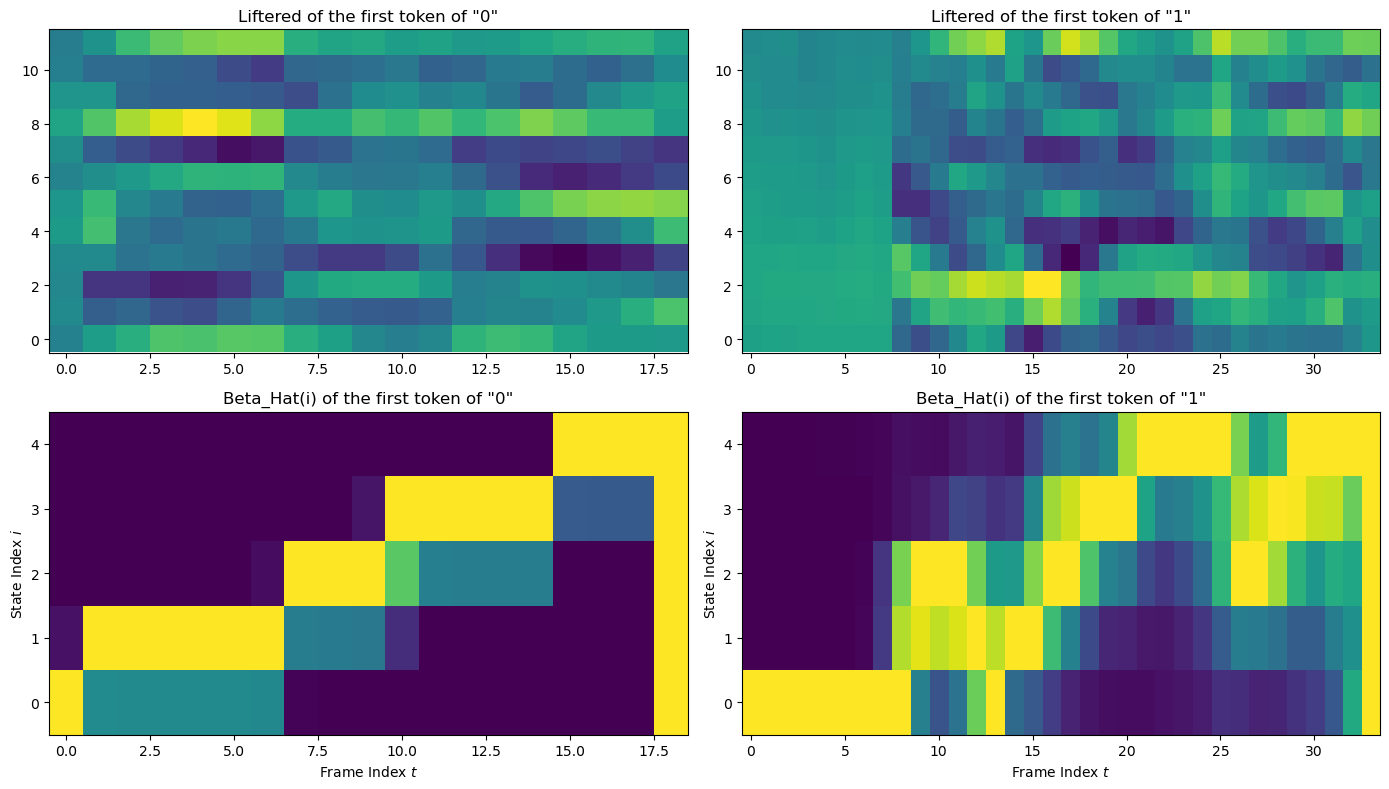

In [37]:
fig, axs = plt.subplots(2,2,figsize=(14,8))
Y=[0,1]
for col in range(2):
    y = Y[col]
    axs[0,col].imshow(train_feat[y][0][:,1:].T,aspect='auto',origin='lower')
    axs[0,col].set_title('Liftered of the first token of "%s"'%(y))
    axs[1,col].imshow(Beta_dict[y][0].T,aspect='auto',origin='lower')
    axs[1,col].set_title('Beta_Hat(i) of the first token of "%s"'%(y))
    axs[1,col].set_ylabel('State Index $i$')
    axs[1,col].set_xlabel('Frame Index $t$')
fig.tight_layout()

In [38]:
importlib.reload(submitted)
Gamma_dict = { y:[] for y in [0,1] }
Xi_dict = { y:[] for y in [0,1] }
for y in [0,1]:
    for n, (B, Alpha_Hat, Beta_Hat) in enumerate(zip(B_dict[y], Alpha_dict[y], Beta_dict[y])):
        Gamma, Xi = submitted.posteriors(Lambda[y][0], B, Alpha_Hat, Beta_Hat)
        Gamma_dict[y].append(Gamma)
        Xi_dict[y].append(Xi)
    print('Gamma_dict[%s] is a list of %d Gamma matrices'%(y,len(Gamma_dict[y])))

Gamma_dict[0] is a list of 150 Gamma matrices
Gamma_dict[1] is a list of 1000 Gamma matrices


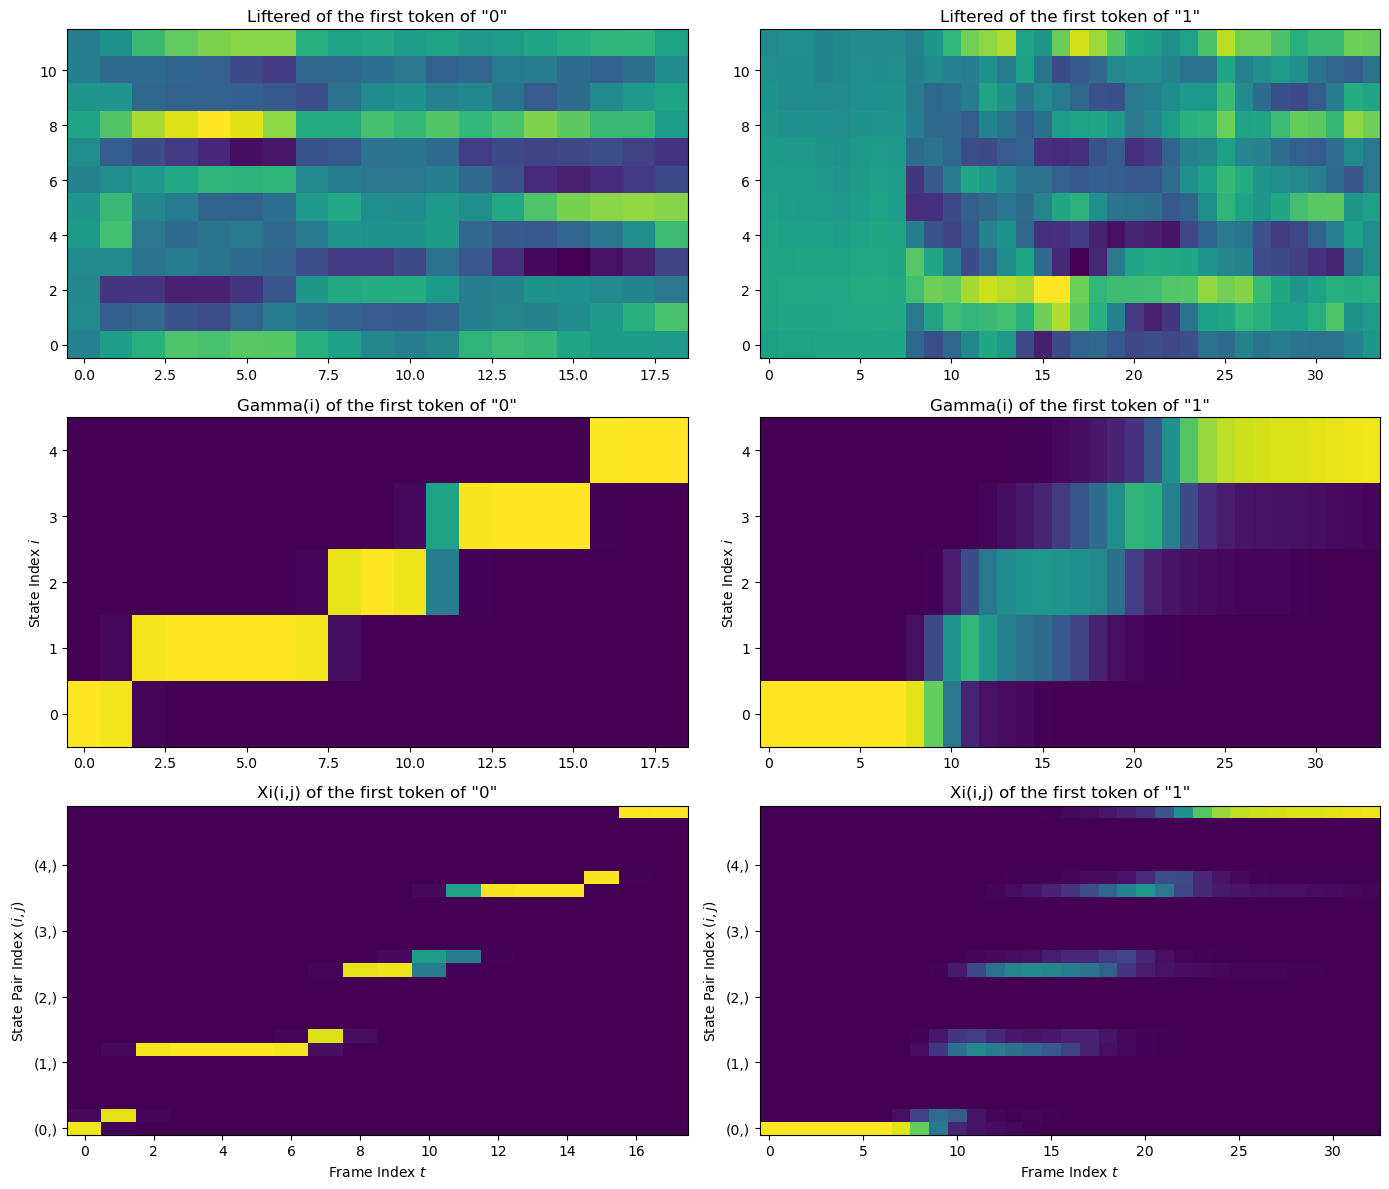

In [39]:
fig, axs = plt.subplots(3,2,figsize=(14,12))
Y=[0,1]
for col in range(2):
    y = Y[col]
    axs[0,col].imshow(train_feat[y][0][:,1:].T,aspect='auto',origin='lower')
    axs[0,col].set_title('Liftered of the first token of "%s"'%(y))
    axs[1,col].imshow(Gamma_dict[y][0].T,aspect='auto',origin='lower')
    axs[1,col].set_title('Gamma(i) of the first token of "%s"'%(y))
    axs[1,col].set_ylabel('State Index $i$')
    (nframes,states)=Gamma_dict[y][0].shape
    axs[2,col].imshow(Xi_dict[y][0].reshape((nframes-1,nstates*nstates)).T,aspect='auto',origin='lower')
    axs[2,col].set_title('Xi(i,j) of the first token of "%s"'%(y))
    axs[2,col].set_ylabel('State Pair Index $(i,j)$')
    axs[2,col].set_yticks([0,5,10,15,20])
    axs[2,col].set_yticklabels(['(0,)','(1,)','(2,)','(3,)','(4,)'])
    axs[2,col].set_xlabel('Frame Index $t$')
fig.tight_layout()


In [40]:
importlib.reload(submitted)
expectations = {}
for y in [0,1]:
    expectations[y] = submitted.E_step(np.concatenate(train_feat[y]), np.concatenate(Gamma_dict[y]), np.concatenate(Xi_dict[y]))
    print('expectations[%s] is a tuple with %d elements'%(y,len(expectations[y])))

expectations[0] is a tuple with 6 elements
expectations[1] is a tuple with 6 elements


In [41]:
for y in [0,1]:
    print('\nFor class "%s":'%(y))
    print('    the A numerator is:')
    print(expectations[y][0])
    print('    the A denominator is:')
    print(expectations[y][1])
    print('    the Mu numerator is:')
    print(expectations[y][2][:,:4])
    print('    the Mu denominator is:')
    print(expectations[y][3])
    print('    the diagonal of the Sigma numerator is:')
    for i in range(5):
        print(np.diag(expectations[y][4][i,:4,:4]))
    print('    the Sigma denominator is:')
    print(expectations[y][5])



For class "0":
    the A numerator is:
[[288.61084924 150.           0.           0.           0.        ]
 [  0.         363.85124173 149.99999906   0.           0.        ]
 [  0.           0.         392.35923699 149.32842458   0.        ]
 [  0.           0.           0.         240.56262721 149.18647922]
 [  0.           0.           0.           0.         549.10114196]]
    the A denominator is:
[438.61084924 513.85124079 541.68766157 389.74910643 549.10114196]
    the Mu numerator is:
[[ -12914.61350288   84421.71933676  -54479.9884261  -143599.00825291]
 [ -89651.23166011  110314.07610839  -77944.27047302 -133310.11242359]
 [  85792.5074258    61111.23091374  -79825.13641099   62886.68277927]
 [ -22485.18791807   88279.9308791    -5334.24916285  -16305.19823729]
 [  -1159.63879196   74174.47481592  163042.18055748  -36427.7140287 ]]
    the Mu denominator is:
[438.61084924 513.85124173 542.35923605 389.89105179 698.28762119]
    the diagonal of the Sigma numerator is:
[107193

In [42]:
importlib.reload(submitted)
Lambda_new = {
    0: submitted.M_step(*expectations[0], 1),
    1: submitted.M_step(*expectations[1], 1),
}
for y in Lambda.keys():
    print('\nThe new A matrix for class "%s" is \n'%(y), Lambda_new[y][0])


The new A matrix for class "0" is 
 [[0.6580112  0.3419888  0.         0.         0.        ]
 [0.         0.70808672 0.29191328 0.         0.        ]
 [0.         0.         0.72432744 0.27567256 0.        ]
 [0.         0.         0.         0.61722432 0.38277568]
 [0.         0.         0.         0.         1.        ]]

The new A matrix for class "1" is 
 [[0.84253724 0.15746276 0.         0.         0.        ]
 [0.         0.80848944 0.19151056 0.         0.        ]
 [0.         0.         0.81758347 0.18241653 0.        ]
 [0.         0.         0.         0.82412481 0.17587519]
 [0.         0.         0.         0.         1.        ]]


### Testing on the train set, make sure things look ok

Also for visualizing stuff, see about SVM necessity.

In [43]:
importlib.reload(submitted)
password_train = submitted.recognize(train_feat[0], Lambda_new) 
print("passwords recognized")
oov_train =  submitted.recognize(train_feat[1], Lambda_new)
print("oov recognized")

passwords recognized
oov recognized


In [44]:
print("Predictions on train set, class 0:")
print(password_train[1])
print("Predictions on train set, class 1:")
print(oov_train[1])

Predictions on train set, class 0:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predictions on train set, class 1:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [45]:
print("Log probs on train set, class 0:")
print(password_train[0])
print("Log probs on train set, class 1:")
print(oov_train[0])

Log probs on train set, class 0:
{0: array([-1563.50175256, -1254.63368167, -1495.29250848, -1278.20787537,
       -1013.2734819 , -1535.35456607, -1013.4487913 , -1031.44439637,
       -1047.25860789, -1547.97633422, -1482.31414339, -1497.81235684,
       -1486.02818461, -1479.73401756, -1238.7928045 , -1511.53068415,
       -1513.98736597, -1297.55842263, -1387.00249828, -1247.10641327,
       -1341.59946695, -1245.32483053, -1243.33939426, -1282.20351689,
       -1488.82897826, -1266.50136654, -1193.68741373, -1502.11725781,
       -1309.61844297, -1254.17093834, -1052.55134388, -1429.66437346,
       -1464.47920603, -1039.47093674, -1299.79762353, -1292.71567686,
       -1315.38913433, -1475.24845313, -1288.02837074, -1272.78032262,
       -1432.06055663, -1263.54078973, -1270.55825288, -2032.78152907,
       -1026.15526684, -2492.04015766, -1008.3416454 , -1267.54723215,
       -1252.35350642, -1488.7563527 , -1489.54790503, -1235.1035642 ,
       -1656.90905279, -1555.52941648, -

### Visualizing some of that data

-1367.5415846777878
-2264.7502629716814
-1781.3455692606613


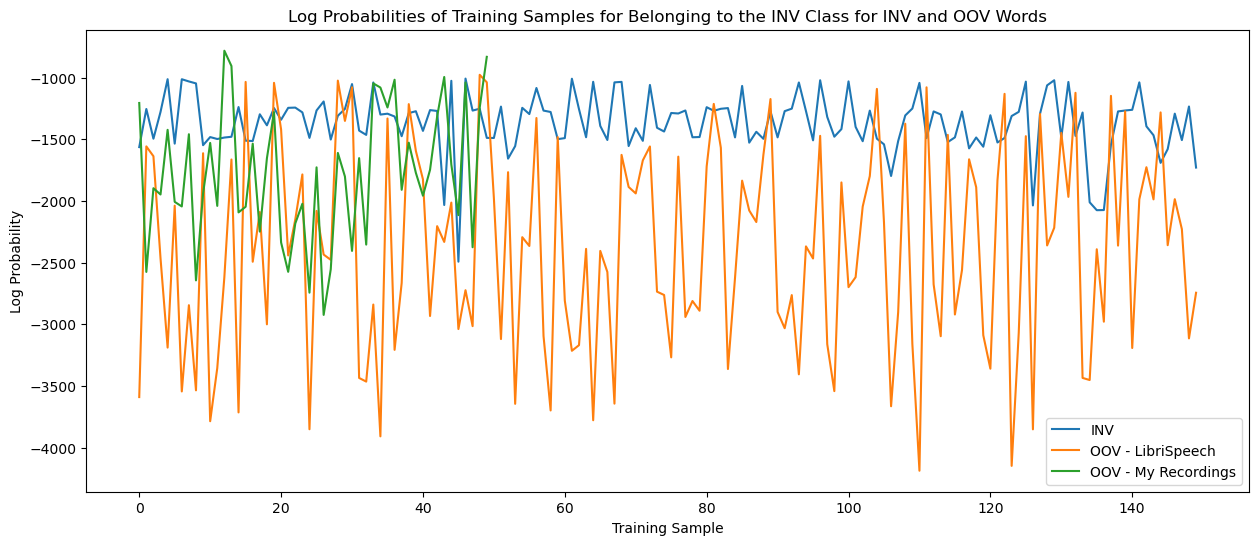

In [46]:
# compare probability of being in class 0 for password and oov words
plt.figure(figsize=(15,6))
plt.plot(password_train[0][0],label='INV')
plt.plot(oov_train[0][0][0:150],label='OOV - LibriSpeech')
plt.plot(oov_train[0][0][950:1000],label='OOV - My Recordings')
plt.title("Log Probabilities of Training Samples for Belonging to the INV Class for INV and OOV Words")
plt.ylabel("Log Probability")
plt.xlabel("Training Sample")
plt.legend()

print(password_train[0][0].mean())
print(oov_train[0][0].mean())
print(oov_train[0][0][950:1000].mean())

Generally, probability of being in class 0 is higher for class 0, lower for class 1 but doesn't separate amazingly well.

-1477.9150475658846
-1950.3131668088874
-1591.1944161743063


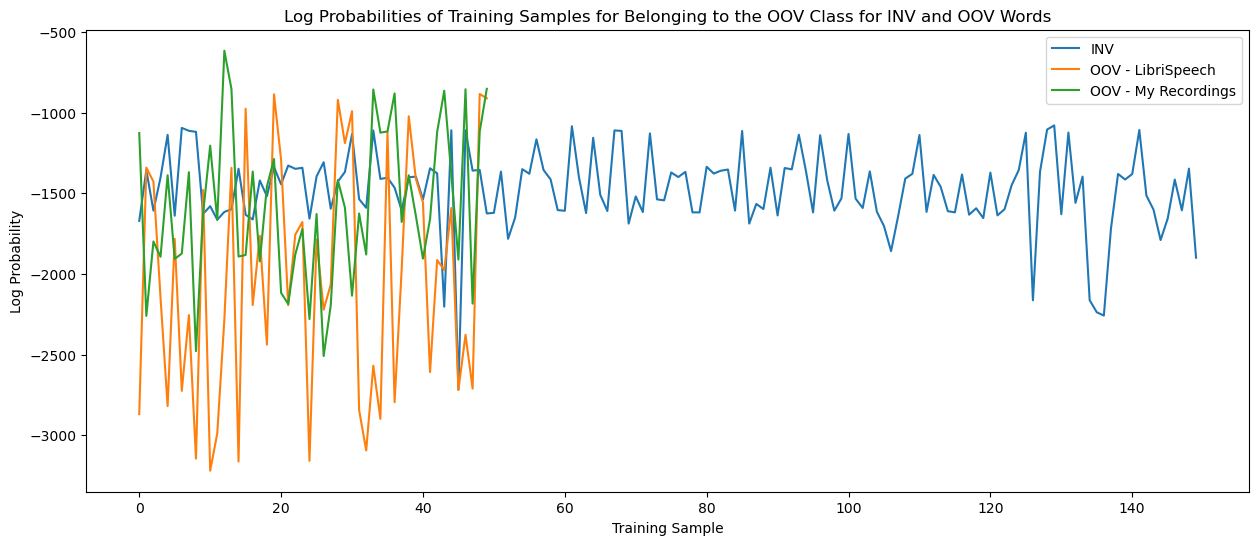

In [47]:
# compare probability of being in class 1 for password and oov words
plt.figure(figsize=(15,6))
plt.plot(password_train[0][1],label='INV')
plt.plot(oov_train[0][1][0:50],label='OOV - LibriSpeech')
plt.plot(oov_train[0][1][950:1000],label='OOV - My Recordings')
plt.title("Log Probabilities of Training Samples for Belonging to the OOV Class for INV and OOV Words")
plt.ylabel("Log Probability")
plt.xlabel("Training Sample")
plt.legend()

print(password_train[0][1].mean())
print(oov_train[0][1].mean())
print(oov_train[0][1][950:1000].mean())

Not great, p(class 1) follows same trend as above, which should be reversed, so that's not great to separate on.

In [48]:
# check out difference (ratio) of probability of being in group 0 (password) vs group 1 (oov)

a = password_train[0][0]-password_train[0][1]
b = oov_train[0][0][0:150] - oov_train[0][1][0:150]
c = oov_train[0][0][950:1000] - oov_train[0][1][950:1000]

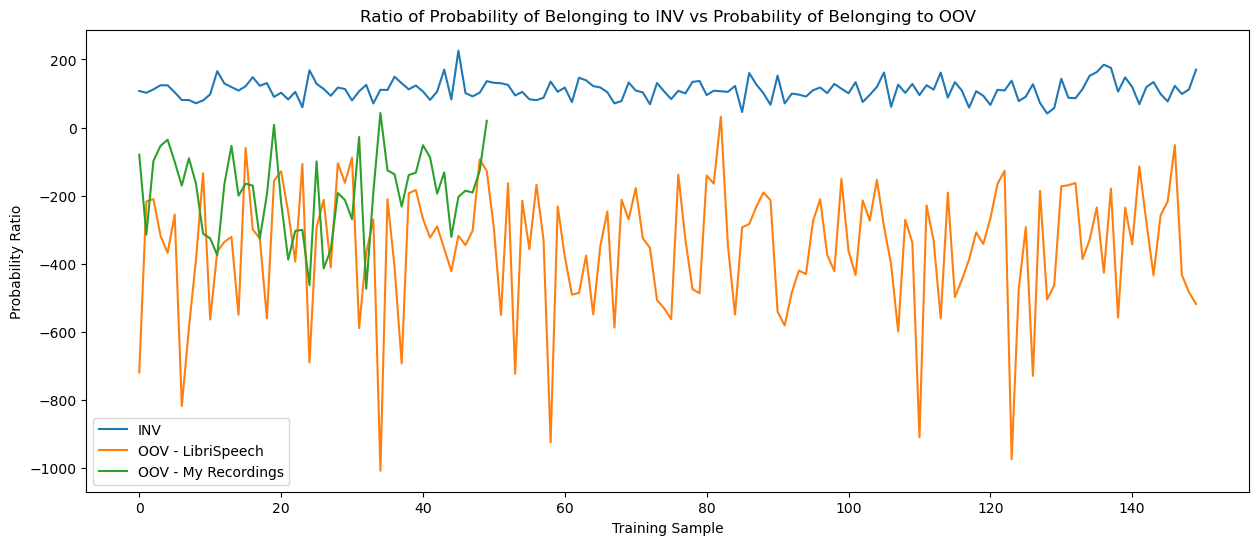

In [49]:
plt.figure(figsize=(15,6))
plt.plot(a,label='INV')
plt.plot(b,label='OOV - LibriSpeech')
plt.plot(c,label='OOV - My Recordings')

plt.title("Ratio of Probability of Belonging to INV vs Probability of Belonging to OOV")
plt.ylabel("Probability Ratio")
plt.xlabel("Training Sample")
plt.legend()

Close, but ratio of probabilities gives some better separability.

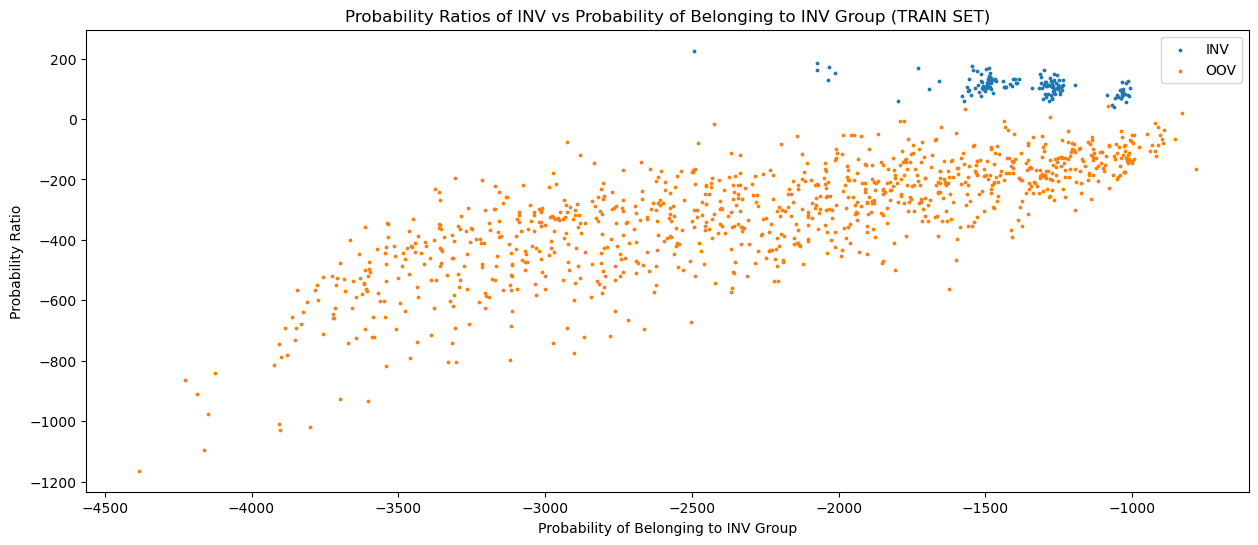

In [50]:
# Ratio of probabilties vs probability of being in class 0
plt.figure(figsize=(15,6))
plt.scatter(password_train[0][0], (password_train[0][0]-password_train[0][1]),label='INV',s=3)
plt.scatter(oov_train[0][0], (oov_train[0][0]-oov_train[0][1]),label='OOV',s=3)

plt.title("Probability Ratios of INV vs Probability of Belonging to INV Group (TRAIN SET)")
plt.ylabel("Probability Ratio")
plt.xlabel("Probability of Belonging to INV Group")
plt.legend()

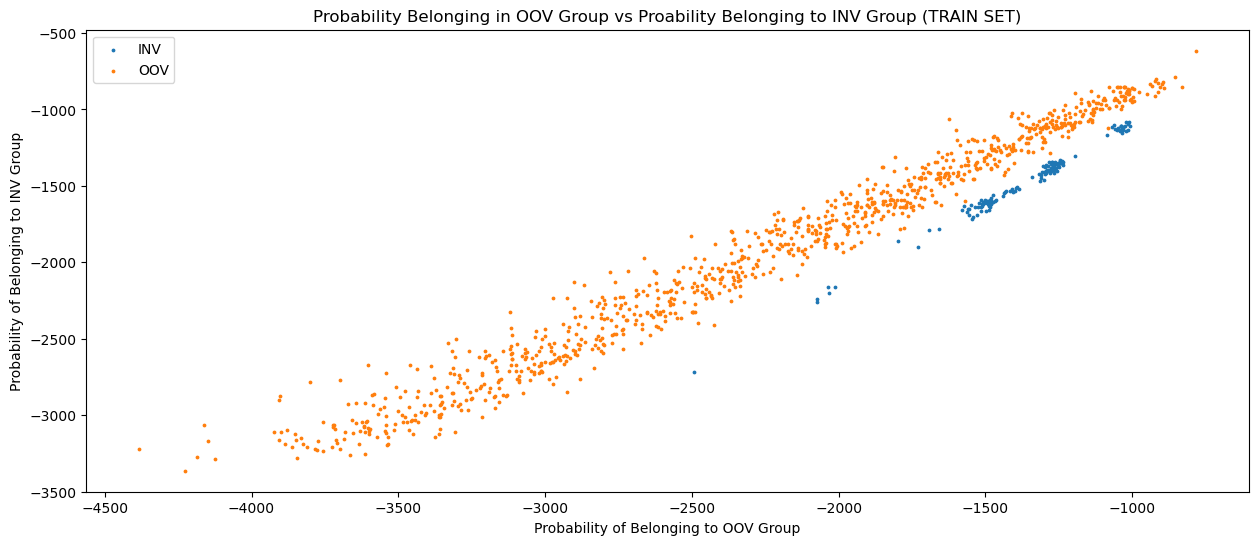

In [51]:
# Probability of being in class 0 vs class 1
plt.figure(figsize=(15,6))
plt.scatter(password_train[0][0], password_train[0][1],label='INV',s=3)
plt.scatter(oov_train[0][0], oov_train[0][1],label='OOV',s=3)

plt.title("Probability Belonging in OOV Group vs Proability Belonging to INV Group (TRAIN SET)")
plt.ylabel("Probability of Belonging to INV Group")
plt.xlabel("Probability of Belonging to OOV Group")
plt.legend()

In [52]:
password_dev = submitted.recognize(dev_feat[0], Lambda_new) 
print("passwords recognized")
oov_dev =  submitted.recognize(dev_feat[1], Lambda_new)
print("oov recognized")

passwords recognized
oov recognized


In [53]:
print("Predictions on train set, class 0:")
print(password_dev[1])
print("Predictions on train set, class 1:")
print(oov_dev[1])

Predictions on train set, class 0:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predictions on train set, class 1:
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


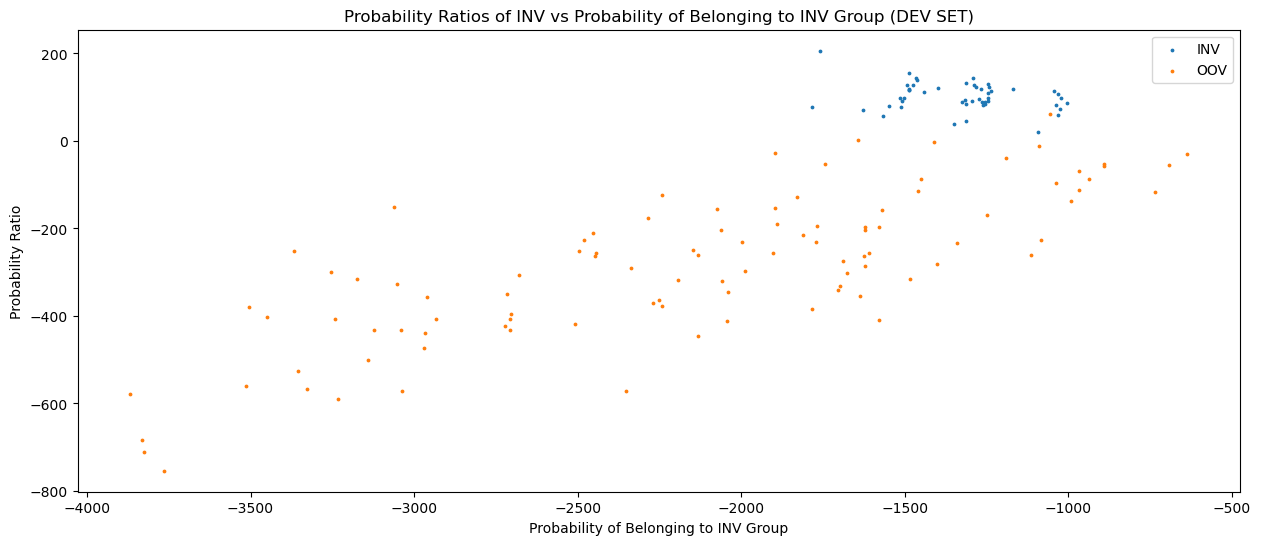

In [54]:
# Ratio of probabilties vs probability of being in class 0
plt.figure(figsize=(15,6))
plt.scatter(password_dev[0][0], (password_dev[0][0]-password_dev[0][1]),label='INV',s=3)
plt.scatter(oov_dev[0][0], (oov_dev[0][0]-oov_dev[0][1]),label='OOV',s=3)

plt.title("Probability Ratios of INV vs Probability of Belonging to INV Group (DEV SET)")
plt.ylabel("Probability Ratio")
plt.xlabel("Probability of Belonging to INV Group")
plt.legend()

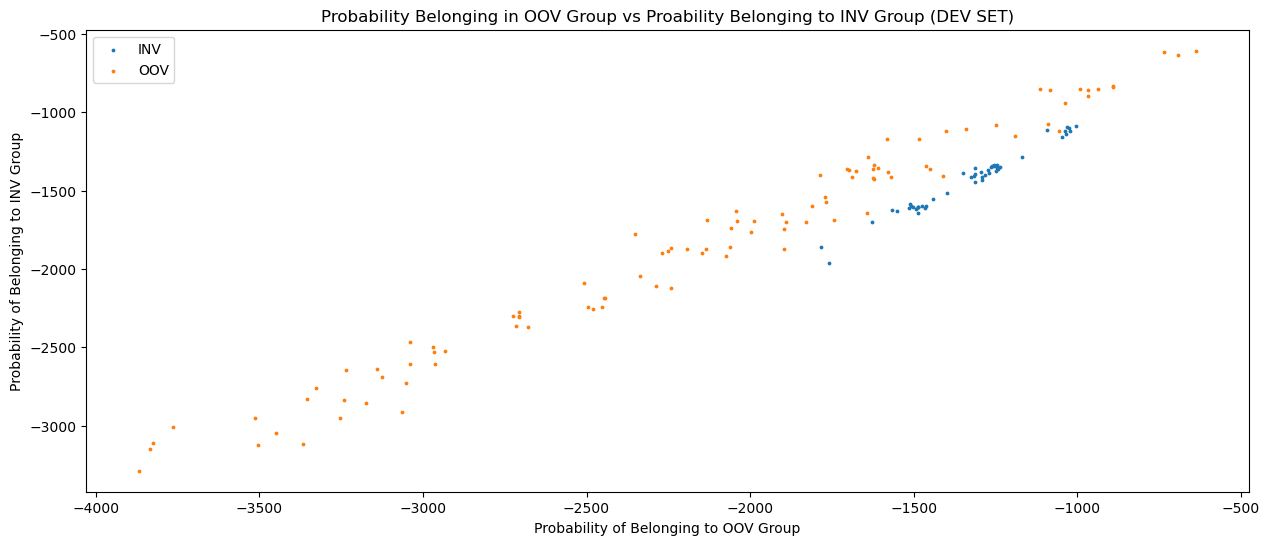

In [55]:
# Probability of being in class 0 vs class 1
plt.figure(figsize=(15,6))
plt.scatter(password_dev[0][0], password_dev[0][1],label='INV',s=3)
plt.scatter(oov_dev[0][0], oov_dev[0][1],label='OOV',s=3)

plt.title("Probability Belonging in OOV Group vs Proability Belonging to INV Group (DEV SET)")
plt.ylabel("Probability of Belonging to INV Group")
plt.xlabel("Probability of Belonging to OOV Group")
plt.legend()

Data indicates we could use an svm to separate for very good accuracy.

## Testing training with batches and epochs

In [56]:
nbatches = 5
epochs = 3
nstates = 5

print("0 class batch size = {}".format(len(train_zero.keys())/nbatches))
print("1 class batch size = {}".format(len(train_one.keys())/nbatches))

0 class batch size = 30.0
1 class batch size = 200.0


In [57]:
rlist0 = [i for i in range(len(train_zero.keys()))]
random.shuffle(rlist0)

rlist1 = [i for i in range(len(train_one.keys()))]
random.shuffle(rlist1)

In [58]:
importlib.reload(submitted)
rlist0 = [i for i in range(len(train_zero.keys()))]
rlist1 = [i for i in range(len(train_one.keys()))]

batch_size_0 = len(train_zero.keys())//nbatches
batch_size_1 = len(train_one.keys())//nbatches

for n in range(epochs):
    
    print("Training epoch " + str(n))
    
    random.shuffle(rlist0)
    random.shuffle(rlist1)
    
    for b in range(nbatches):

        print("\tTraining batch " + str(b))

        batch_feat = {0:[],1:[]}

        for i in range(batch_size_0):
            idx = rlist0[batch_size_0 * b + i]
            batch_feat[0].append(train_feat[0][idx])

        for i in range(batch_size_1):
            idx = rlist1[batch_size_1 * b + i]
            batch_feat[1].append(train_feat[1][idx])

        if b==0 and n==0:   
            Lambda = {
                0: submitted.initialize_hmm(batch_feat[0], nstates),
                1: submitted.initialize_hmm(batch_feat[1], nstates)
            }

        B_dict = { y:[] for y in [0,1] }
        for y in [0,1]:
            for X in batch_feat[y]:
                B = submitted.observation_pdf(X, Lambda[y][1], Lambda[y][2])
                B_dict[y].append(B)

        Alpha_dict = { y:[] for y in [0,1] }
        G_dict = { y:[] for y in [0,1] }
        for y in [0,1]:
            for B in B_dict[y]:
                Alpha_Hat, G = submitted.scaled_forward(Lambda[y][0], B)
                Alpha_dict[y].append(Alpha_Hat)
                G_dict[y].append(G)

        Beta_dict = { y:[] for y in [0,1] }
        for y in [0,1]:
            for B in B_dict[y]:
                Beta_Hat = submitted.scaled_backward(Lambda[y][0], B)
                Beta_dict[y].append(Beta_Hat)

        Gamma_dict = { y:[] for y in [0,1] }
        Xi_dict = { y:[] for y in [0,1] }
        for y in [0,1]:
            for n, (B, Alpha_Hat, Beta_Hat) in enumerate(zip(B_dict[y], Alpha_dict[y], Beta_dict[y])):
                Gamma, Xi = submitted.posteriors(Lambda[y][0], B, Alpha_Hat, Beta_Hat)
                Gamma_dict[y].append(Gamma)
                Xi_dict[y].append(Xi)

        expectations = {}
        for y in [0,1]:
            expectations[y] = submitted.E_step(np.concatenate(batch_feat[y]), np.concatenate(Gamma_dict[y]), np.concatenate(Xi_dict[y]))

        Lambda = {
            0: submitted.M_step(*expectations[0], 1),
            1: submitted.M_step(*expectations[1], 1),
        }

print("Done")

Training epoch 0
	Training batch 0
	Training batch 1
	Training batch 2
	Training batch 3
	Training batch 4
Training epoch 1
	Training batch 0
	Training batch 1
	Training batch 2
	Training batch 3
	Training batch 4
Training epoch 2
	Training batch 0
	Training batch 1
	Training batch 2
	Training batch 3
	Training batch 4
Done


In [59]:
password_train_batch = submitted.recognize(train_feat[0], Lambda) 
print("passwords recognized")
oov_train_batch =  submitted.recognize(train_feat[1], Lambda)
print("oov recognized")

passwords recognized
oov recognized


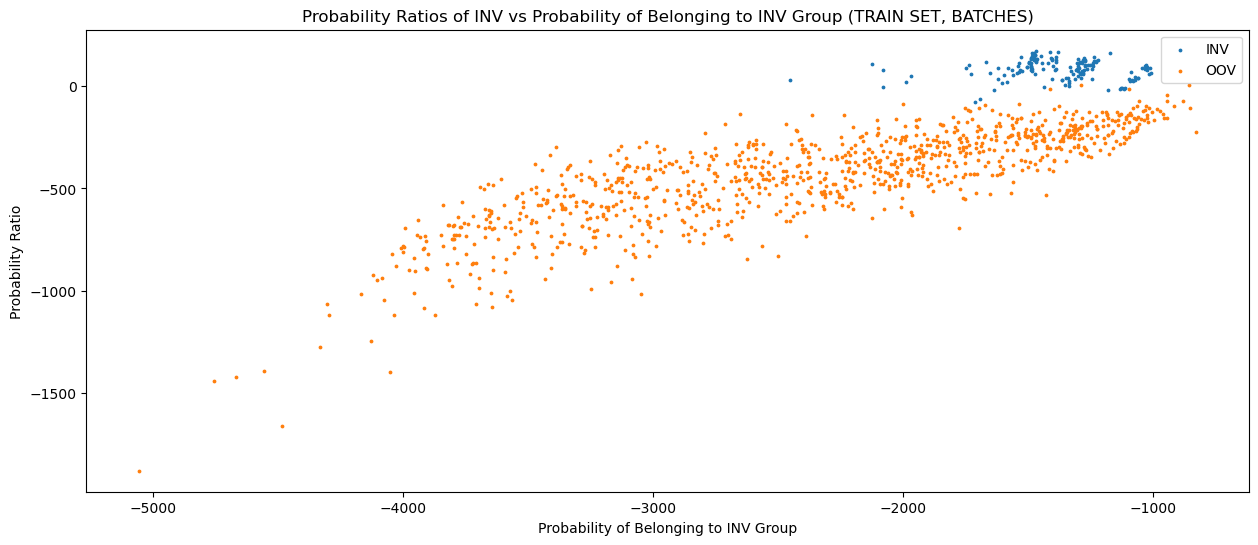

In [60]:
# Ratio of probabilties vs probability of being in class 0
plt.figure(figsize=(15,6))
plt.scatter(password_train_batch[0][0], (password_train_batch[0][0]-password_train_batch[0][1]),label='INV',s=3)
plt.scatter(oov_train_batch[0][0], (oov_train_batch[0][0]-oov_train_batch[0][1]),label='OOV',s=3)

plt.title("Probability Ratios of INV vs Probability of Belonging to INV Group (TRAIN SET, BATCHES)")
plt.ylabel("Probability Ratio")
plt.xlabel("Probability of Belonging to INV Group")
plt.legend()

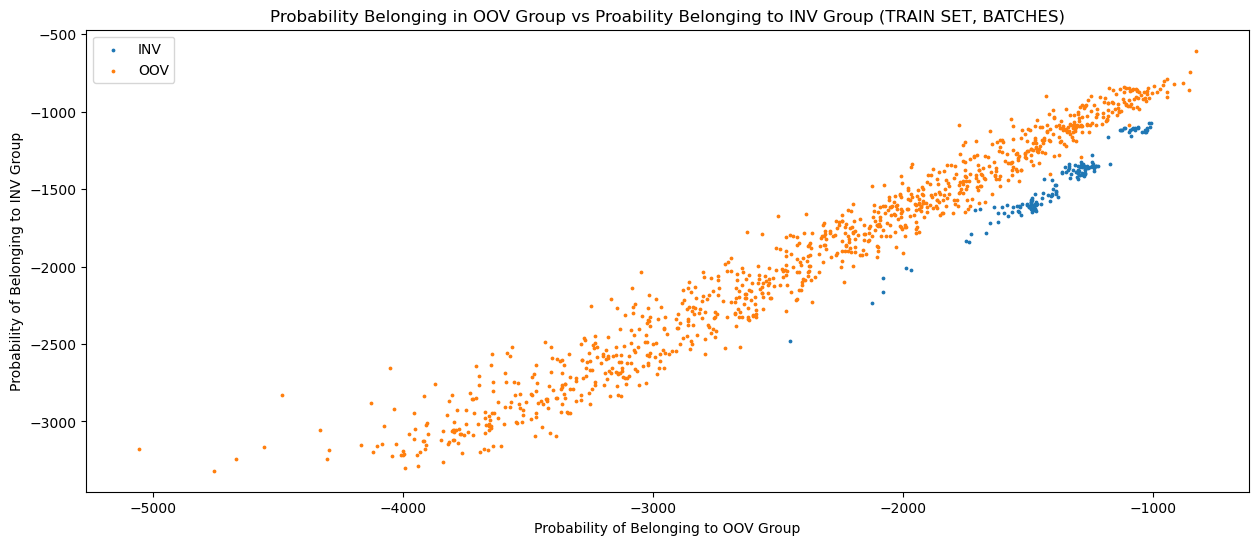

In [61]:
# Probability of being in class 0 vs class 1
plt.figure(figsize=(15,6))
plt.scatter(password_train_batch[0][0], password_train_batch[0][1],label='INV',s=3)
plt.scatter(oov_train_batch[0][0], oov_train_batch[0][1],label='OOV',s=3)

plt.title("Probability Belonging in OOV Group vs Proability Belonging to INV Group (TRAIN SET, BATCHES)")
plt.ylabel("Probability of Belonging to INV Group")
plt.xlabel("Probability of Belonging to OOV Group")
plt.legend()

In [62]:
password_dev_batch = submitted.recognize(dev_feat[0], Lambda) 
print("passwords recognized")
oov_dev_batch =  submitted.recognize(dev_feat[1], Lambda)
print("oov recognized")

passwords recognized
oov recognized


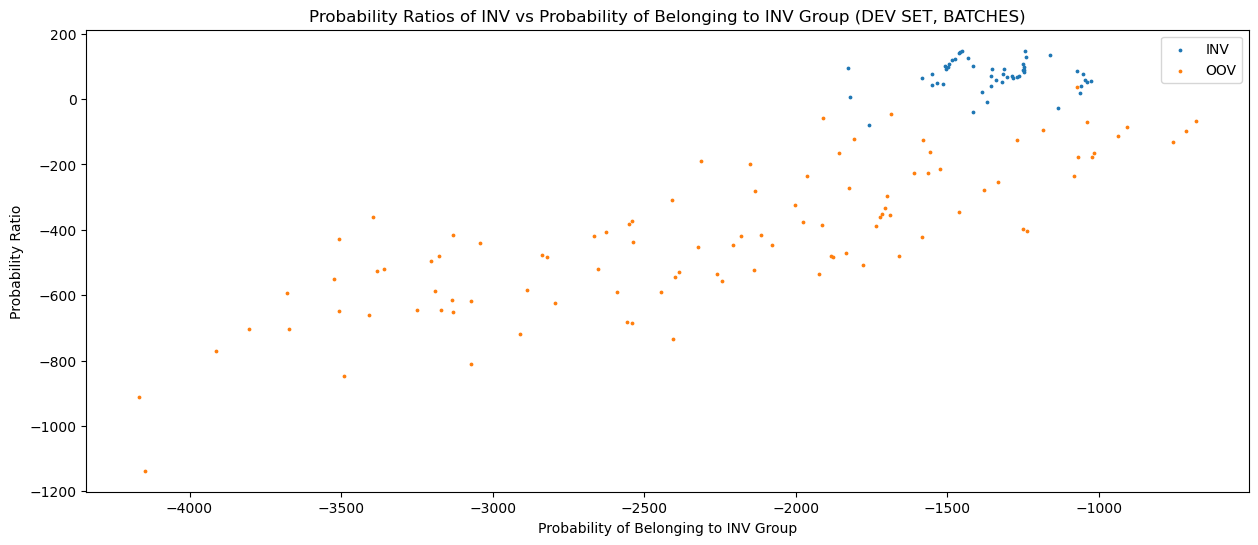

In [63]:
# Ratio of probabilties vs probability of being in class 0
plt.figure(figsize=(15,6))
plt.scatter(password_dev_batch[0][0], (password_dev_batch[0][0]-password_dev_batch[0][1]),label='INV',s=3)
plt.scatter(oov_dev_batch[0][0], (oov_dev_batch[0][0]-oov_dev_batch[0][1]),label='OOV',s=3)

plt.title("Probability Ratios of INV vs Probability of Belonging to INV Group (DEV SET, BATCHES)")
plt.ylabel("Probability Ratio")
plt.xlabel("Probability of Belonging to INV Group")
plt.legend()

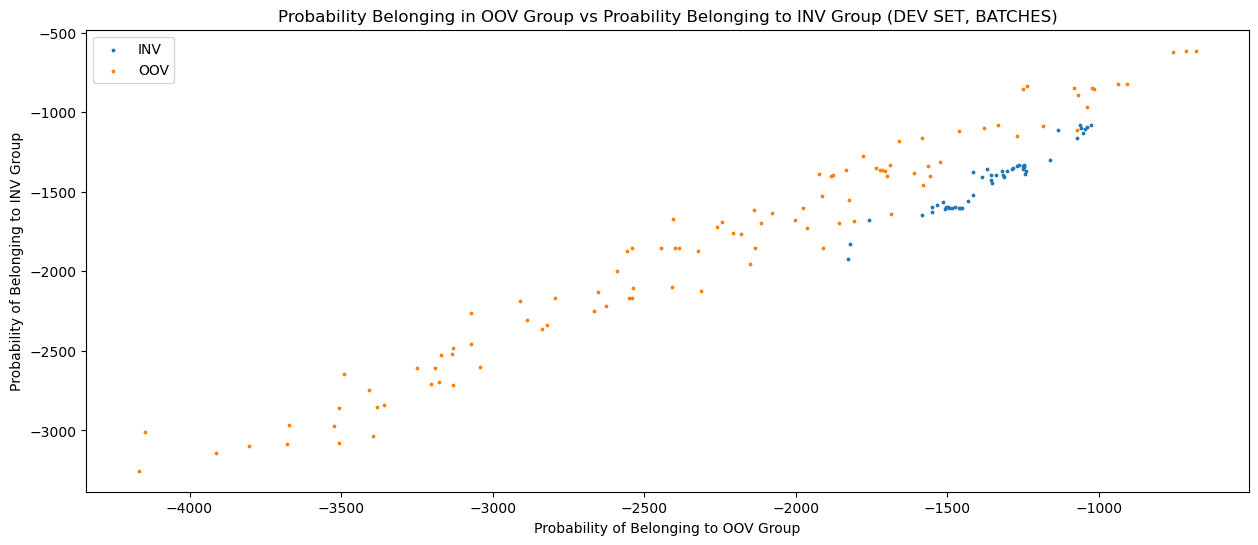

In [64]:
# Probability of being in class 0 vs class 1
plt.figure(figsize=(15,6))
plt.scatter(password_dev_batch[0][0], password_dev_batch[0][1],label='INV',s=3)
plt.scatter(oov_dev_batch[0][0], oov_dev_batch[0][1],label='OOV',s=3)

plt.title("Probability Belonging in OOV Group vs Proability Belonging to INV Group (DEV SET, BATCHES)")
plt.ylabel("Probability of Belonging to INV Group")
plt.xlabel("Probability of Belonging to OOV Group")
plt.legend()

### Just epochs

In [65]:
for n in range(epochs):

    print("Training epoch " + str(n))

    if n==0:   
        Lambda = {
            0: submitted.initialize_hmm(batch_feat[0], nstates),
            1: submitted.initialize_hmm(batch_feat[1], nstates)
        }

    B_dict = { y:[] for y in [0,1] }
    for y in [0,1]:
        for X in train_feat[y]:
            B = submitted.observation_pdf(X, Lambda[y][1], Lambda[y][2])
            B_dict[y].append(B)

    Alpha_dict = { y:[] for y in [0,1] }
    G_dict = { y:[] for y in [0,1] }
    for y in [0,1]:
        for B in B_dict[y]:
            Alpha_Hat, G = submitted.scaled_forward(Lambda[y][0], B)
            Alpha_dict[y].append(Alpha_Hat)
            G_dict[y].append(G)

    Beta_dict = { y:[] for y in [0,1] }
    for y in [0,1]:
        for B in B_dict[y]:
            Beta_Hat = submitted.scaled_backward(Lambda[y][0], B)
            Beta_dict[y].append(Beta_Hat)

    Gamma_dict = { y:[] for y in [0,1] }
    Xi_dict = { y:[] for y in [0,1] }
    for y in [0,1]:
        for n, (B, Alpha_Hat, Beta_Hat) in enumerate(zip(B_dict[y], Alpha_dict[y], Beta_dict[y])):
            Gamma, Xi = submitted.posteriors(Lambda[y][0], B, Alpha_Hat, Beta_Hat)
            Gamma_dict[y].append(Gamma)
            Xi_dict[y].append(Xi)

    expectations = {}
    for y in [0,1]:
        expectations[y] = submitted.E_step(np.concatenate(train_feat[y]), np.concatenate(Gamma_dict[y]), np.concatenate(Xi_dict[y]))

    Lambda = {
        0: submitted.M_step(*expectations[0], 1),
        1: submitted.M_step(*expectations[1], 1),
    }


Training epoch 0
Training epoch 1
Training epoch 2


In [66]:
password_train_epochs = submitted.recognize(train_feat[0], Lambda) 
print("passwords recognized")
oov_train_epochs =  submitted.recognize(train_feat[1], Lambda)
print("oov recognized")

passwords recognized
oov recognized


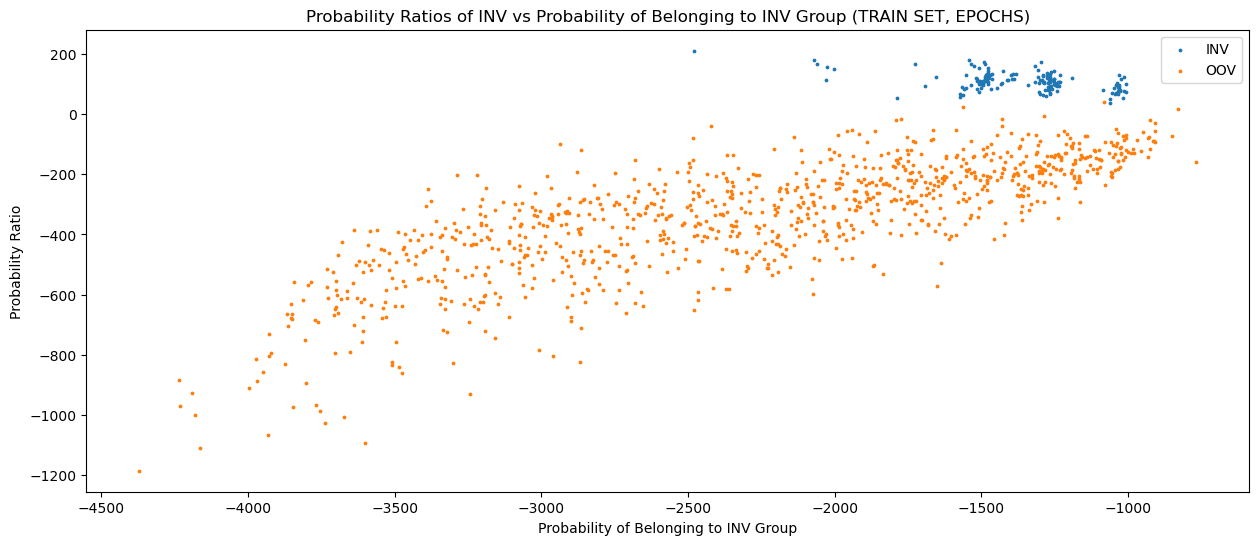

In [67]:
# Ratio of probabilties vs probability of being in class 0
plt.figure(figsize=(15,6))
plt.scatter(password_train_epochs[0][0], (password_train_epochs[0][0]-password_train_epochs[0][1]),label='INV',s=3)
plt.scatter(oov_train_epochs[0][0], (oov_train_epochs[0][0]-oov_train_epochs[0][1]),label='OOV',s=3)

plt.title("Probability Ratios of INV vs Probability of Belonging to INV Group (TRAIN SET, EPOCHS)")
plt.ylabel("Probability Ratio")
plt.xlabel("Probability of Belonging to INV Group")
plt.legend()

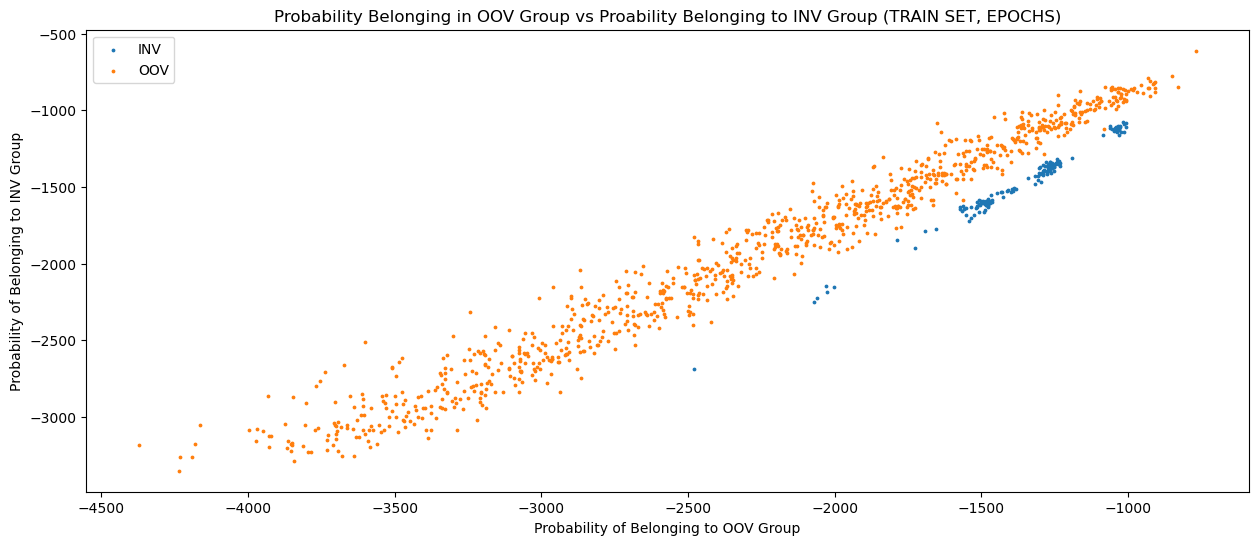

In [68]:
# Probability of being in class 0 vs class 1
plt.figure(figsize=(15,6))
plt.scatter(password_train_epochs[0][0], password_train_epochs[0][1],label='INV',s=3)
plt.scatter(oov_train_epochs[0][0], oov_train_epochs[0][1],label='OOV',s=3)

plt.title("Probability Belonging in OOV Group vs Proability Belonging to INV Group (TRAIN SET, EPOCHS)")
plt.ylabel("Probability of Belonging to INV Group")
plt.xlabel("Probability of Belonging to OOV Group")
plt.legend()

In [69]:
password_dev_epochs = submitted.recognize(dev_feat[0], Lambda) 
print("passwords recognized")
oov_dev_epochs =  submitted.recognize(dev_feat[1], Lambda)
print("oov recognized")

passwords recognized
oov recognized


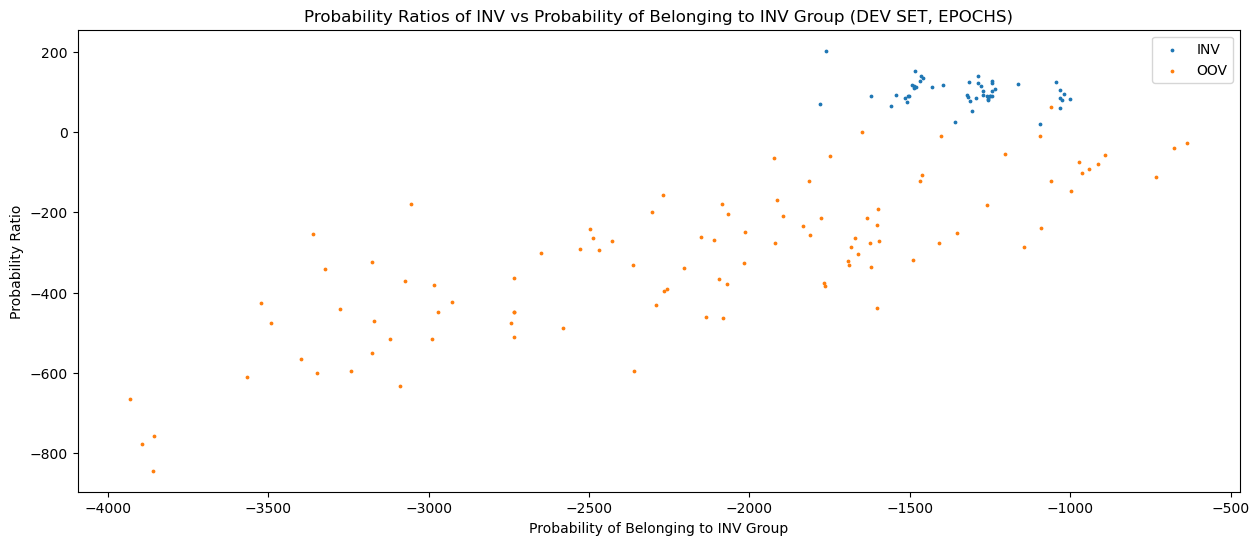

In [70]:
# Ratio of probabilties vs probability of being in class 0
plt.figure(figsize=(15,6))
plt.scatter(password_dev_epochs[0][0], (password_dev_epochs[0][0]-password_dev_epochs[0][1]),label='INV',s=3)
plt.scatter(oov_dev_epochs[0][0], (oov_dev_epochs[0][0]-oov_dev_epochs[0][1]),label='OOV',s=3)

plt.title("Probability Ratios of INV vs Probability of Belonging to INV Group (DEV SET, EPOCHS)")
plt.ylabel("Probability Ratio")
plt.xlabel("Probability of Belonging to INV Group")
plt.legend()

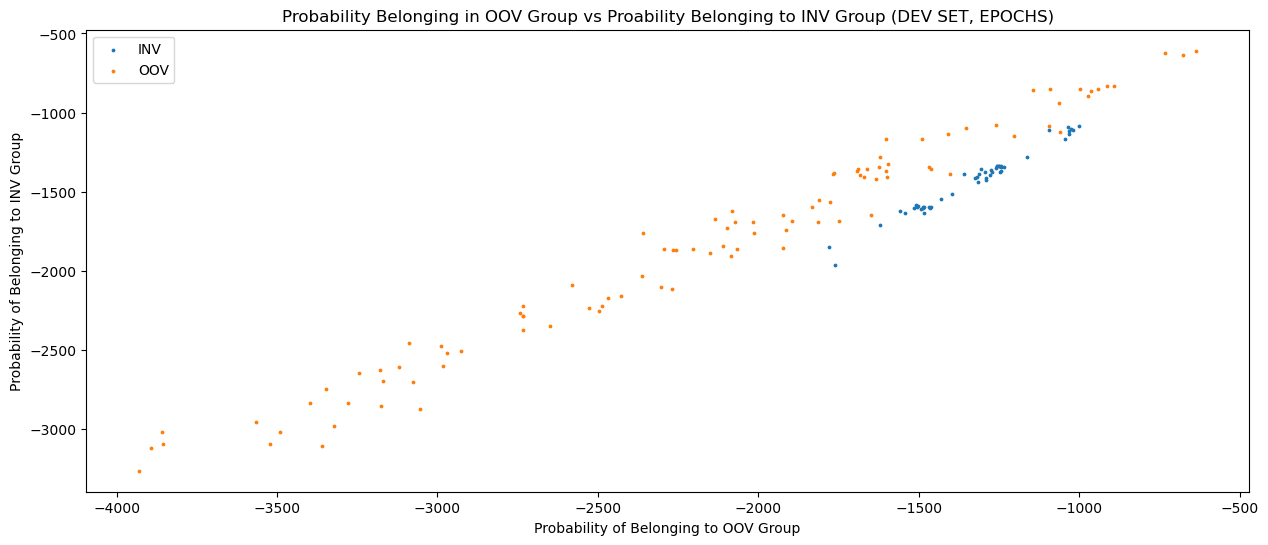

In [71]:
# Probability of being in class 0 vs class 1
plt.figure(figsize=(15,6))
plt.scatter(password_dev_epochs[0][0], password_dev_epochs[0][1],label='INV',s=3)
plt.scatter(oov_dev_epochs[0][0], oov_dev_epochs[0][1],label='OOV',s=3)

plt.title("Probability Belonging in OOV Group vs Proability Belonging to INV Group (DEV SET, EPOCHS)")
plt.ylabel("Probability of Belonging to INV Group")
plt.xlabel("Probability of Belonging to OOV Group")
plt.legend()

## SVM

In [72]:
# for visualization
def make_meshgrid(x, y, h=10):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

### SVM with just ratios

In [73]:
p = len(password_train[0][0])
o = len(oov_train[0][0])

X = np.zeros((p + o,1))
y = np.zeros(p + o)
X[0:p,0] = password_train[0][0]-password_train[0][1]

X[p:p+o,0] = oov_train[0][0]-oov_train[0][1]
y[p:p+o] = 1


clf_poly = make_pipeline(StandardScaler(), SVC(kernel='poly',max_iter=100000,class_weight='balanced',gamma='auto'))
clf_rbf = make_pipeline(StandardScaler(), SVC(kernel='rbf',max_iter=100000,class_weight='balanced',gamma='auto'))
clf_sig = make_pipeline(StandardScaler(), SVC(kernel='sigmoid',max_iter=100000,class_weight='balanced',gamma='auto'))

clf_poly.fit(X,y)
clf_rbf.fit(X,y)
clf_sig.fit(X,y)

ratio_classifiers = [clf_poly, clf_rbf, clf_sig]

### SVM with ratios vs probabilities

In [74]:
p = len(password_train[0][0])
o = len(oov_train[0][0])


X = np.zeros((p + o,2))
y = np.zeros(p + o)
X[0:p,0] = password_train[0][0]
X[0:p,1] = password_train[0][0]-password_train[0][1]

X[p:p+o,0] = oov_train[0][0]
X[p:p+o,1] = oov_train[0][0]-oov_train[0][1]
y[p:p+o] = 1


clf_poly = make_pipeline(StandardScaler(), SVC(kernel='poly',max_iter=100000,class_weight='balanced',gamma='auto'))
clf_rbf = make_pipeline(StandardScaler(), SVC(kernel='rbf',max_iter=100000,class_weight='balanced',gamma='auto'))
clf_sig = make_pipeline(StandardScaler(), SVC(kernel='sigmoid',max_iter=100000,class_weight='balanced',gamma='auto'))

clf_poly.fit(X,y)
clf_rbf.fit(X,y)
clf_sig.fit(X,y)



prob_classifiers = [clf_poly, clf_rbf, clf_sig]

print(prob_classifiers[0])
print(prob_classifiers[1])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', gamma='auto', kernel='poly',
                     max_iter=100000))])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', gamma='auto', max_iter=100000))])


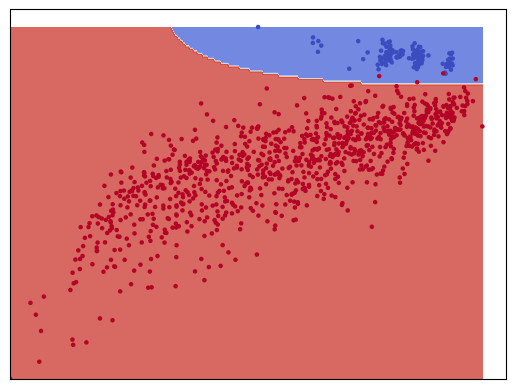

In [75]:
y_temp = prob_classifiers[0].predict(X)

fig, ax = plt.subplots()
# title for the plots

# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(ax, prob_classifiers[1], xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=5)
ax.set_xticks(())
ax.set_yticks(())

plt.show()

### SVM with probabilities for both class 0 and 1

In [76]:
p = len(password_train[0][0])
o = len(oov_train[0][0])

X = np.zeros((p + o,3))
y = np.zeros(p + o)
X[0:p,0] = password_train[0][0]
X[0:p,1] = password_train[0][1]
X[0:p,2] = password_train[0][0]-password_train[0][1]

X[p:p+o,0] = oov_train[0][0]
X[p:p+o,1] = oov_train[0][1]
X[p:p+o,2] = oov_train[0][0]-oov_train[0][1]
y[p:p+o] = 1

clf_poly = make_pipeline(StandardScaler(), SVC(kernel='poly',max_iter=100000,class_weight='balanced',gamma='auto'))
clf_rbf = make_pipeline(StandardScaler(), SVC(kernel='rbf',max_iter=100000,class_weight='balanced',gamma='auto'))
clf_sig = make_pipeline(StandardScaler(), SVC(kernel='sigmoid',max_iter=100000,class_weight='balanced',gamma='auto'))

clf_poly.fit(X,y)
clf_rbf.fit(X,y)
clf_sig.fit(X,y)

prob2_classifiers = [clf_poly, clf_rbf, clf_sig]

## Testing

### SVM - ratios only

In [77]:
from sklearn.metrics import classification_report

In [78]:
p = len(password_dev[0][0])
o = len(oov_dev[0][0])

X_dev = np.zeros((p + o,1))
y_dev = np.zeros(p + o)
X_dev[0:p,0] = password_dev[0][0]-password_dev[0][1]

X_dev[p:p+o,0] = oov_dev[0][0]-oov_dev[0][1]
y_dev[p:p+o] = 1


predictY = np.zeros((len(X_dev),3))
for idx, clf in enumerate(ratio_classifiers):
    print(clf)
    predictY[:,idx] = clf.predict(X_dev)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', gamma='auto', kernel='poly',
                     max_iter=100000))])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', gamma='auto', max_iter=100000))])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', gamma='auto', kernel='sigmoid',
                     max_iter=100000))])


In [79]:
print("Poly")
print(classification_report(y_dev, predictY[:,0]))
print("\n")

print("RBF")
print(classification_report(y_dev, predictY[:,1]))
print("\n")

print("Sig")
print(classification_report(y_dev, predictY[:,2]))
print("\n")

Poly
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



RBF
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



Sig
              precision    recall  f1-score   support

         0.0       0.57      0.86      0.68        50
         1.0       0.91      0.67      0.77       100

    accuracy                           0.73       150
   macro avg       0.74      0.77      0.73       150
weighted avg       0.79      0.73      0.74       150





### SVM - probability vs ratio

In [80]:
p = len(password_dev[0][0])
o = len(oov_dev[0][0])

X_dev = np.zeros((p + o,2))
y_dev = np.zeros(p + o)

X_dev[0:p,0] = password_dev[0][0]
X_dev[0:p,1] = password_dev[0][0]-password_dev[0][1]

X_dev[p:p+o,0] = oov_dev[0][0]
X_dev[p:p+o,1] = oov_dev[0][0]-oov_dev[0][1]
y_dev[p:p+o] = 1


predictY = np.zeros((len(X_dev),3))
for idx, clf in enumerate(prob_classifiers):
    print(clf)
    predictY[:,idx] = clf.predict(X_dev)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', gamma='auto', kernel='poly',
                     max_iter=100000))])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', gamma='auto', max_iter=100000))])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', gamma='auto', kernel='sigmoid',
                     max_iter=100000))])


In [82]:
print("Poly")
print(classification_report(y_dev, predictY[:,0]))
print("\n")

print("RBF")
print(classification_report(y_dev, predictY[:,1]))
print("\n")

print("Sig")
print(classification_report(y_dev, predictY[:,2]))
print("\n")

Poly
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



RBF
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



Sig
              precision    recall  f1-score   support

         0.0       0.68      0.84      0.75        50
         1.0       0.91      0.80      0.85       100

    accuracy                           0.81       150
   macro avg       0.79      0.82      0.80       150
weighted avg       0.83      0.81      0.82       150





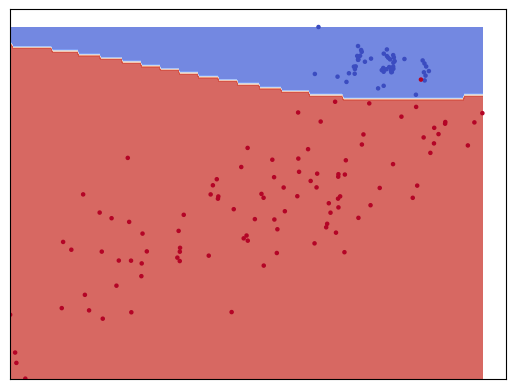

In [83]:
fig, ax = plt.subplots()
# title for the plots

# Set-up grid for plotting.
X0, X1 = X_dev[:, 0], X_dev[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(ax, prob_classifiers[0], xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_dev, cmap=plt.cm.coolwarm, s=5)
ax.set_xticks(())
ax.set_yticks(())

plt.show()

### SVM - use both probabilities vs ratio

In [84]:
p = len(password_dev[0][0])
o = len(oov_dev[0][0])

X_dev = np.zeros((p + o,3))
y_dev = np.zeros(p + o)

X_dev[0:p,0] = password_dev[0][0]
X_dev[0:p,1] = password_dev[0][1]
X_dev[0:p,2] = password_dev[0][0]-password_dev[0][1]

X_dev[p:p+o,0] = oov_dev[0][0]
X_dev[p:p+o,1] = oov_dev[0][1]
X_dev[p:p+o,2] = oov_dev[0][0]-oov_dev[0][1]
y_dev[p:p+o] = 1

predictY = np.zeros((len(X_dev),3))
for idx, clf in enumerate(prob2_classifiers):
    print(clf)
    predictY[:,idx] = clf.predict(X_dev)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', gamma='auto', kernel='poly',
                     max_iter=100000))])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', gamma='auto', max_iter=100000))])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', gamma='auto', kernel='sigmoid',
                     max_iter=100000))])


In [85]:
print("Poly")
print(classification_report(y_dev, predictY[:,0]))
print("\n")

print("RBF")
print(classification_report(y_dev, predictY[:,1]))
print("\n")

print("Sig")
print(classification_report(y_dev, predictY[:,2]))
print("\n")

Poly
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



RBF
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        50
         1.0       1.00      0.97      0.98       100

    accuracy                           0.98       150
   macro avg       0.97      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



Sig
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83        50
         1.0       0.92      0.91      0.91       100

    accuracy                           0.89       150
   macro avg       0.87      0.88      0.87       150
weighted avg       0.89      0.89      0.89       150





Performances were very similar for polynomial kernels for all. Best performing:

### Test with epochs and batches

In [89]:
p = len(password_train_batch[0][0])
o = len(oov_train_batch[0][0])

X = np.zeros((p + o,3))
y = np.zeros(p + o)
X[0:p,0] = password_train_batch[0][0]
X[0:p,1] = password_train_batch[0][1]
X[0:p,2] = password_train_batch[0][0]-password_train_batch[0][1]

X[p:p+o,0] = oov_train_batch[0][0]
X[p:p+o,1] = oov_train_batch[0][1]
X[p:p+o,2] = oov_train_batch[0][0]-oov_train_batch[0][1]
y[p:p+o] = 1


clf_poly_prob2_batches = make_pipeline(StandardScaler(), SVC(kernel='poly',max_iter=100000,class_weight='balanced',gamma='auto'))

clf_poly_prob2_batches.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', gamma='auto', kernel='poly',
                     max_iter=100000))])

In [90]:
p = len(password_dev_batch[0][0])
o = len(oov_dev_batch[0][0])

X_dev = np.zeros((p + o,3))
y_dev = np.zeros(p + o)

X_dev[0:p,0] = password_dev_batch[0][0]
X_dev[0:p,1] = password_dev_batch[0][1]
X_dev[0:p,2] = password_dev_batch[0][0]-password_dev_batch[0][1]

X_dev[p:p+o,0] = oov_dev_batch[0][0]
X_dev[p:p+o,1] = oov_dev_batch[0][1]
X_dev[p:p+o,2] = oov_dev_batch[0][0]-oov_dev_batch[0][1]

y_dev[p:p+o] = 1

predictY = clf_poly_prob2_batches.predict(X_dev)
print(classification_report(y_dev, predictY))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96        50
         1.0       0.99      0.97      0.98       100

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



In [91]:
p = len(password_train_epochs[0][0])
o = len(oov_train_epochs[0][0])

X = np.zeros((p + o,3))
y = np.zeros(p + o)
X[0:p,0] = password_train_epochs[0][0]
X[0:p,1] = password_train_epochs[0][1]
X[0:p,2] = password_train_epochs[0][0]-password_train_epochs[0][1]

X[p:p+o,0] = oov_train_epochs[0][0]
X[p:p+o,1] = oov_train_epochs[0][1]
X[p:p+o,2] = oov_train_epochs[0][0]-oov_train_epochs[0][1]
y[p:p+o] = 1


clf_poly_prob2_epochs = make_pipeline(StandardScaler(), SVC(kernel='poly',max_iter=100000,class_weight='balanced',gamma='auto'))

clf_poly_prob2_epochs.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', gamma='auto', kernel='poly',
                     max_iter=100000))])

In [93]:
p = len(password_dev_epochs[0][0])
o = len(oov_dev_epochs[0][0])

X_dev = np.zeros((p + o,3))
y_dev = np.zeros(p + o)

X_dev[0:p,0] = password_dev_epochs[0][0]
X_dev[0:p,1] = password_dev_epochs[0][1]
X_dev[0:p,2] = password_dev_epochs[0][0]-password_dev_epochs[0][1]

X_dev[p:p+o,0] = oov_dev_epochs[0][0]
X_dev[p:p+o,1] = oov_dev_epochs[0][1]
X_dev[p:p+o,2] = oov_dev_epochs[0][0]-oov_dev_epochs[0][1]

y_dev[p:p+o] = 1

predictY = clf_poly_prob2_epochs.predict(X_dev)
print(classification_report(y_dev, predictY))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



Batches degrade performance - likely because it emphasizes the last batch the model saw. No significant differences anywhere really. Moving forward with epochs

### Hyperparameter tuning

In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import PredefinedSplit

In [95]:
tp = len(password_train_epochs[0][0]) # number of features in train password set
to = len(oov_train_epochs[0][0]) # number of features in train oov set

dp = len(password_dev_epochs[0][0]) # feat in dev passwrod set
do = len(oov_dev_epochs[0][0]) # feat in dev oov set

X = np.zeros((tp + to + dp + do,3))
y = np.zeros(tp + to + dp + do)
test_fold = np.zeros(tp + to + dp + do) # 0 means validation set

# put in train password set
sl = slice(0,tp)
X[sl,0] = password_train_epochs[0][0]
X[sl,1] = password_train_epochs[0][1]
X[sl,2] = password_train_epochs[0][0]-password_train_epochs[0][1]
test_fold[sl] = -1 # mark as training

# put in train oov set
sl = slice(tp,tp+to)
X[sl,0] = oov_train_epochs[0][0]
X[sl,1] = oov_train_epochs[0][1]
X[sl,2] = oov_train_epochs[0][0]-oov_train_epochs[0][1]
y[sl] = 1
test_fold[sl] = -1 # mark as training

# put in dev password set
sl = slice(tp+to,tp+to+dp)
X[sl,0] = password_dev_epochs[0][0]
X[sl,1] = password_dev_epochs[0][1]
X[sl,2] = password_dev_epochs[0][0]-password_dev_epochs[0][1]

# dev oov set
sl = slice(tp+to+dp,tp+to+dp+do)
X[sl,0] = oov_dev_epochs[0][0]
X[sl,1] = oov_dev_epochs[0][1]
X[sl,2] = oov_dev_epochs[0][0]-oov_dev_epochs[0][1]
y[sl] = 1

# grab train and dev sets so we can train and test later
X_train = X[0:tp+to,:]
y_train = y[0:tp+to]

X_dev = X[tp+to:tp+to+dp+do,:]
y_dev = y[tp+to:tp+to+dp+do]

# shuffle
X, y, test_fold = shuffle(X, y, test_fold)

In [96]:
# grid search for optimal parameters
ps = PredefinedSplit(test_fold)

svc = SVC(kernel='poly',class_weight='balanced',max_iter=1000000)
scaler = StandardScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("svc", svc)])

C_range = np.logspace(-10, 10, 21) # try C from 1e-10 to 1e10
gamma_range = np.logspace(-10, 5, 16) # try gamma from 1e-10 to 1e5
degree_range = np.linspace(1,10,10).astype(np.int16)

param_grid = {"svc__gamma":gamma_range, "svc__C":C_range, "svc__degree":degree_range}

# will raise a lot of convergence warnings
grid = GridSearchCV(pipe, param_grid=param_grid, cv=ps)
grid.fit(X, y)

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            kernel='poly',
                                            max_iter=1000000))]),
             param_grid={'svc__C': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                         'svc__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int16),
                         'svc__gamma': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])})

In [97]:
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

print(grid.cv_results_.keys())
a = grid.cv_results_['mean_test_score']
masked = np.ma.array(a, mask=np.isnan(a))
bests = np.argwhere(masked>0.99)

print("\nBest idxs: {}".format(bests[:,0]))
print("Best scores: {}".format(grid.cv_results_['mean_test_score'][bests][:,0]))

Cs = grid.cv_results_['param_svc__C'][bests][:,0]
degrees = grid.cv_results_['param_svc__degree'][bests][:,0]
gammas = grid.cv_results_['param_svc__gamma'][bests][:,0]

print("\nBest Cs: {}".format(Cs))
print("Best degrees: {}".format(degrees))
print("Best gammas: {}".format(gammas))

The best parameters are {'svc__C': 1e-10, 'svc__degree': 3, 'svc__gamma': 1000.0} with a score of 0.99
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_svc__C', 'param_svc__degree', 'param_svc__gamma', 'params', 'split0_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

Best idxs: [  45  107  205  267  364  395  524  527  555  684  715  843  975 1003
 1066 1098 1134 1135 1163 1194 1226 1258 1293 1294 1322 1354 1386 1452
 1453 1482 1514 1611 1612 1642 1770 1771 1801 1929 1930 1935 1961 1993
 2088 2089 2095 2121 2153 2185 2247 2248 2255 2280 2313 2345 2406 2407
 2415 2440 2505 2537 2565 2566 2575 2600 2697 2724 2725 2759 2792 2883
 2884 2919 2952 3042 3043 3079 3112 3201 3202 3238 3304]
Best scores: [0.99333333 0.99333333 0.99333333 0.99333333 0.99333333 0.99333333
 0.99333333 0.99333333 0.99333333 0.99333333 0.99333333 0.99333333
 0.99333333 0.99333333 0.99333333 0.99333333 0.99333333 0.99333333
 0.99333333 0.99333333 0.99333333

In [99]:
for i in range(len(Cs)):
    
    print("Index {}".format(i))
    svc = SVC(kernel='poly',class_weight='balanced',max_iter=1000000,C=Cs[i],gamma=gammas[i],degree=degrees[i])
    scaler = StandardScaler()
    pipe = Pipeline(steps=[("scaler", scaler), ("svc", svc)])

    pipe.fit(X_train,y_train)
    predictY = pipe.predict(X_dev)
    print(classification_report(y_dev, predictY))

Index 0
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Index 1
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Index 2
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        50
         1.0       1.00      0.96      0.98       100

    accuracy                           0.97       150
   macro avg       0.96      0.98      0.97       150
weighted avg       0.98      0.97      0.97       150

Index 8
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Index 9
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Ind

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Index 40
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Index 41
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

I

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Index 57
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Index 58
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

I

C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amant\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Index 63
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Index 64
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

I

They all have practically the same performance, but we wanted to check for oness that didn't get to reach their maximum iterations. We choose idx 0.

In [111]:
i = 0
svc = SVC(kernel='poly',class_weight='balanced',max_iter=1000000,gamma="auto")
scaler = StandardScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("svc", svc)])

pipe.fit(X_train,y_train)
predictY = pipe.predict(X_dev)
print(classification_report(y_dev, predictY))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



## Putting it together and testing on the train set

In [118]:
def predict(X, Lambda, clf):
    logprob,_ = submitted.recognize(X, Lambda)
    
    svmfeat = np.zeros((len(logprob[0]),3))
    svmfeat[:,0] = logprob[0]
    svmfeat[:,1] = logprob[1]
    svmfeat[:,2] = logprob[0]-logprob[1]
    predictY = clf.predict(svmfeat)
    
    return predictY

In [119]:
predictY0 = predict(test_feat[0],Lambda,pipe)
predictY1 = predict(test_feat[1],Lambda,pipe)

In [120]:
print("Predictions for class 0:", predictY0)
print("Predictions for class 1:", predictY1)

Predictions for class 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Predictions for class 1: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


## Saving the model

In [121]:
import pickle

In [122]:
with open('lambda.pickle', 'wb') as handle:
    pickle.dump(Lambda, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [123]:
with open('clf.pickle', 'wb') as handle:
    pickle.dump(pipe, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [127]:
with open('lambda.pickle', 'rb') as handle:
    Lambda_new = pickle.load(handle)

In [128]:
with open('clf.pickle', 'rb') as handle:
    clf_new = pickle.load(handle)

In [129]:
predictY0 = predict(test_feat[0],Lambda_new,clf_new)
predictY1 = predict(test_feat[1],Lambda_new,clf_new)

In [130]:
print("Predictions for class 0:", predictY0)
print("Predictions for class 1:", predictY1)

Predictions for class 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Predictions for class 1: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [137]:
def confusion_matrix(predictY0, predictY1):
    mat = np.zeros((2,2))
    
    mat[0,0] = len(predictY0) - np.sum(predictY0) # TP - classified as password (0) that was password (0)
    mat[0,1] = len(predictY1) - np.sum(predictY1) # FP - classified as password (0) that was OOV (1)
    mat[1,0] = np.sum(predictY0) # FN - classified as OOV (1) that was password (0)
    mat[1,1] = np.sum(predictY1) # TN - classified as OOV (1) that was OOV (1)
    
    precision = mat[0,0] / (mat[0,0] + mat[0,1]) # TP / TP + FP
    recall = mat[0,0] / (mat[0,0] + mat[1,0]) # TP / TP + FN
    specificity = mat[1,1] / (mat[1,1] + mat[0,1]) # TN / TN + FP
    
    return mat,precision,recall,specificity

In [138]:
conf_mat, prec, rec, spec = confusion_matrix(predictY0, predictY1)

In [141]:
print("Confusion matrix: \n{}".format(conf_mat))
print("Precision: {}".format(prec))
print("Recall: {}".format(rec))
print("Specificity: {}".format(spec))

Confusion matrix: 
[[49.  1.]
 [ 1. 99.]]
Precision: 0.98
Recall: 0.98
Specificity: 0.99
